In [5]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

**Paso 1. Preparamos el dataset**

In [6]:
# 1) Cargar datos
monthly = pd.read_csv('resources_dataset/1_data/consumption_data/non_smart_meter/monthly_consumption.csv')
smart15 = pd.read_csv('resources_dataset/1_data/consumption_data/smart_meter/15min_interval/smart_15min_1.csv')
billing = pd.read_csv('resources_dataset/1_data/survey_data/wave_3/w3_electricity_billing_info.csv')

In [7]:
# 2) Agregar smart_15min a nivel mensual
smart15['dt'] = pd.to_datetime(smart15['date'].astype(str) + ' ' + smart15['time'].astype(str), errors='coerce')
smart15 = smart15.dropna(subset=['dt'])
smart15['month'] = smart15['dt'].dt.to_period('M').astype(str)

In [8]:
smart_monthly = (
    smart15
    .groupby(['household_ID', 'month'])['importkwh(kwh)']
    .sum()
    .reset_index()
    .rename(columns={'importkwh(kwh)': 'smart_import_kwh'})
)

In [9]:
# 3) Preparar facturación
billing['dt'] = pd.to_datetime(
    billing['reading_smart_meter_data'],
    format='%Y-%m-%d',
    errors='coerce'
)
billing = billing.dropna(subset=['dt'])
billing['month'] = billing['dt'].dt.to_period('M').astype(str)
billing['billed_consumption_kwh'] = pd.to_numeric(billing['target_units_of_consumption'], errors='coerce')
billing_subset = billing[['household_ID', 'month', 'billed_consumption_kwh']]

In [10]:
# 4) Merge
df_int = (
    monthly
    .merge(smart_monthly, on=['household_ID', 'month'], how='left')
    .merge(billing_subset, on=['household_ID', 'month'], how='left')
    .rename(columns={'consumption': 'monthly_consumption_kwh'})
)

In [11]:
# 5) Power Consumption (W)
df2_raw = pd.read_csv('resources_dataset/2_smart_home_energy_consumption.csv')
df2_raw['dt'] = pd.to_datetime(df2_raw['Timestamp'], errors='coerce')
df2 = df2_raw.dropna(subset=['dt']).set_index('dt')
interval2_h = df2.index.to_series().diff().mode()[0].total_seconds() / 3600
df2_energy = (df2['Power Consumption (W)'] * interval2_h / 1000).to_frame('Power Consumption (kWh)')
df2_resampled = df2_energy.resample('15min').sum()

In [12]:
# 6) columnas [kW] a kWh
df4_raw = pd.read_csv(
    'resources_dataset/4_HomeC.csv',
    low_memory=False
)
df4_raw['time'] = pd.to_numeric(df4_raw['time'], errors='coerce')
df4_raw['dt'] = pd.to_datetime(df4_raw['time'], unit='s', errors='coerce')
df4 = df4_raw.dropna(subset=['dt']).set_index('dt')
interval4_h = df4.index.to_series().diff().mode()[0].total_seconds() / 3600
kw_cols = [c for c in df4.columns if '[kW]' in c]
df4_energy = df4[kw_cols] * interval4_h
df4_resampled = df4_energy.resample('15min').sum()

In [13]:
# 7) Ventilador, PC, AC, Lampara, TV (W)
df5_raw = pd.read_excel('resources_dataset/5_Energy_Consumption_Dataset_For_Smart_Homes.xlsx')
df5_raw['dt'] = pd.to_datetime(df5_raw['TimeStamp'], errors='coerce')
df5 = df5_raw.dropna(subset=['dt']).set_index('dt')
interval5_h = df5.index.to_series().diff().mode()[0].total_seconds() / 3600
w_cols = ['Ventilador', 'PC', 'AC', 'Lampara', 'TV']
df5_energy = df5[w_cols] * interval5_h / 1000
df5_resampled = df5_energy.resample('15min').sum()

In [14]:
# 8) Concatenar y presentar
df_iot = pd.concat([df2_resampled, df4_resampled, df5_resampled], axis=1).fillna(0)

In [16]:
# 9) Cargar datos de consumo de smart meter
df9 = pd.read_csv('resources_dataset/1_data/consumption_data/smart_meter/6hour_interval/smart_6hour_1.csv', low_memory=False)
df9['dt'] = pd.to_datetime(df9['DATE'].astype(str) + ' ' + df9['TIME'].astype(str), errors='coerce')
df9 = df9.dropna(subset=['dt'])
df9['month'] = df9['dt'].dt.to_period('M').astype(str)

In [17]:
monthly6h = (
    df9.groupby(['household_ID','month'])['TOTAL_IMPORT (kWh)']
       .sum()
       .reset_index()
       .rename(columns={'TOTAL_IMPORT (kWh)':'smart6h_import_kwh'})
)

In [18]:
# 10) Merge con df_int
df_full = df_int.merge(monthly6h, on=['household_ID','month'], how='left')

In [19]:
# 11) Merge con df_iot
voltA = (
    df9.groupby(['household_ID','month'])['PHASE_A_VOLTAGE (V)']
        .mean()
        .reset_index()
        .rename(columns={'PHASE_A_VOLTAGE (V)':'phaseA_voltage_mean'})
)
df_full = df_full.merge(voltA, on=['household_ID','month'], how='left')

In [20]:
# 12) Merge con df_iot
df_iot = df_iot.reset_index().rename(columns={'index':'dt'})
df_iot['month'] = df_iot['dt'].dt.to_period('M').astype(str)

In [21]:
# 13) Sumar kWh de cada columna-device en cada mes
df_iot_monthly = (
    df_iot
    .groupby('month')
    .sum(numeric_only=True)
    .reset_index()
    .rename(columns=lambda c: c + '_iot_monthly' if c!='month' else c)
)

In [22]:
# 14) Merge con df_full
df_merged = df_full.merge(df_iot_monthly, on='month', how='left')

In [23]:
df_merged.head()

household_ID       month monthly_consumption_kwh  smart_import_kwh  \
0       ID0001  2022-10-31                     116               NaN   
1       ID0001  2022-11-30                     120               NaN   
2       ID0001  2022-12-31                     129               NaN   
3       ID0001  2023-01-31                     102               NaN   
4       ID0001  2023-02-28                     115               NaN   

   billed_consumption_kwh smart6h_import_kwh  phaseA_voltage_mean  \
0                     NaN                NaN                  NaN   
1                     NaN                NaN                  NaN   
2                     NaN                NaN                  NaN   
3                     NaN                NaN                  NaN   
4                     NaN                NaN                  NaN   

   Power Consumption (kWh)_iot_monthly  use [kW]_iot_monthly  \
0                                  NaN                   NaN   
1                                  NaN                   NaN   
2                                  NaN                   NaN   
3                                  NaN                   NaN   
4                                  NaN                   NaN   

   gen [kW]_iot_monthly  ...  Barn [kW]_iot_monthly  Well [kW]_iot_monthly  \
0                   NaN  ...                    NaN                    NaN   
1                   NaN  ...                    NaN                    NaN   
2                   NaN  ...                    NaN                    NaN   
3                   NaN  ...                    NaN                    NaN   
4                   NaN  ...                    NaN                    NaN   

   Microwave [kW]_iot_monthly  Living room [kW]_iot_monthly  \
0                         NaN                           NaN   
1                         NaN                           NaN   
2                         NaN                           NaN   
3                         NaN                           NaN   
4                         NaN                           NaN   

   Solar [kW]_iot_monthly  Ventilador_iot_monthly  PC_iot_monthly  \
0                     NaN                     NaN             NaN   
1                     NaN                     NaN             NaN   
2                     NaN                     NaN             NaN   
3                     NaN                     NaN             NaN   
4                     NaN                     NaN             NaN   

   AC_iot_monthly  Lampara_iot_monthly  TV_iot_monthly  
0             NaN                  NaN             NaN  
1             NaN                  NaN             NaN  
2             NaN                  NaN             NaN  
3             NaN                  NaN             NaN  
4             NaN                  NaN             NaN  

[5 rows x 31 columns]

In [24]:
# Enriqueser df_merge
df_ac = pd.read_csv(
    'resources_dataset/1_data/survey_data/wave_1/w1_ac_roster.csv',
    low_memory=False,
    dtype={
        'no_of_hours_ac_was_on_during_daytime_last_week': float,
        'no_of_hours_ac_was_on_during_night_last_week': float
    }
)

# Haz lo mismo para cada uno:
df_app       = pd.read_csv('resources_dataset/1_data/survey_data/wave_1/w1_appliances.csv',       low_memory=False)
df_demo      = pd.read_csv('resources_dataset/1_data/survey_data/wave_1/w1_demographics.csv',     low_memory=False)
df_fan       = pd.read_csv('resources_dataset/1_data/survey_data/wave_1/w1_fan_roster.csv',       low_memory=False)
df_house     = pd.read_csv('resources_dataset/1_data/survey_data/wave_1/w1_household_information_and_history.csv', low_memory=False)
df_light     = pd.read_csv('resources_dataset/1_data/survey_data/wave_1/w1_light_roster.csv',     low_memory=False)
df_room      = pd.read_csv('resources_dataset/1_data/survey_data/wave_1/w1_room_roster.csv',      low_memory=False)

In [25]:
# 2.1 AC: total de horas de uso en la última semana
ac_feats = (
    df_ac
    .assign(total_ac_hours = 
        df_ac['no_of_hours_ac_was_on_during_daytime_last_week']
      + df_ac['no_of_hours_ac_was_on_during_night_last_week']
    )
    .groupby('household_ID')
    .agg({
        'ac_ID':         'count',        # número de unidades de AC
        'wattage_of_the_ac': 'mean',     # potencia media
        'total_ac_hours':    'sum'       # horas totales semanales
    })
    .rename(columns={
        'ac_ID': 'n_ac_units',
        'wattage_of_the_ac': 'ac_wattage_mean',
        'total_ac_hours': 'ac_hours_last_week'
    })
    .reset_index()
)

# 2.2 Appliances: horas totales de uso semana
app_feats = (
    df_app
    .groupby('household_ID')
    .agg({
        'appliance_ID':              'count',
        'no_of_hours_used_during_last_week': 'sum'
    })
    .rename(columns={
        'appliance_ID': 'n_appliances',
        'no_of_hours_used_during_last_week': 'appliances_hours_last_week'
    })
    .reset_index()
)

# 2.3 Fans
fan_feats = (
    df_fan
    .assign(total_fan_hours =
        df_fan['no_of_hours_fan_was_on_during_daytime_last_week']
      + df_fan['no_of_hours_fan_was_on_during_night_last_week']
    )
    .groupby('household_ID')
    .agg({
        'fan_ID': 'count',
        'total_fan_hours': 'sum'
    })
    .rename(columns={
        'fan_ID': 'n_fans',
        'total_fan_hours': 'fan_hours_last_week'
    })
    .reset_index()
)

# 2.4 Lights
light_feats = (
    df_light
    .assign(total_light_hours =
        df_light['no_of_hours_bulb_was_on_during_daytime_last_week']
      + df_light['no_of_hours_bulb_was_on_during_night_last_week']
    )
    .groupby('household_ID')
    .agg({
        'light_ID': 'count',
        'total_light_hours': 'sum'
    })
    .rename(columns={
        'light_ID': 'n_bulbs',
        'total_light_hours': 'bulbs_hours_last_week'
    })
    .reset_index()
)

# Paso 2.5 corregido: Demográficos
demo_feats = (
    df_demo
    .groupby('household_ID')
    .agg(
        household_size=('member_ID', 'nunique'),
        hh_hours_at_home=('no_of_hours_stayed_at_home_during_last_week', 'mean')
    )
    .reset_index()
)

house_feats = (
    df_house
    .loc[:, ['household_ID', 'type_of_electricity_meter', 'socio_economic_class']]
    .drop_duplicates(subset=['household_ID'])
)


In [26]:
survey_w1 = reduce(
    lambda left, right: left.merge(right, on='household_ID', how='outer'),
    [ac_feats, app_feats, fan_feats, light_feats, demo_feats, house_feats]
)

In [27]:
# Finalmente con df_merged / df_full:
df_final = df_merged.merge(survey_w1, on='household_ID', how='left')
df_final

household_ID       month monthly_consumption_kwh  smart_import_kwh  \
0            ID0001  2022-10-31                     116               NaN   
1            ID0001  2022-11-30                     120               NaN   
2            ID0001  2022-12-31                     129               NaN   
3            ID0001  2023-01-31                     102               NaN   
4            ID0001  2023-02-28                     115               NaN   
...             ...         ...                     ...               ...   
101570       ID4063  2024-06-30                     167               NaN   
101571       ID4063  2024-07-31                     178               NaN   
101572       ID4063  2024-08-31                     165               NaN   
101573       ID4063  2024-09-30                     124               NaN   
101574       ID4063  2024-10-31                     109               NaN   

        billed_consumption_kwh smart6h_import_kwh  phaseA_voltage_mean  \
0                          NaN                NaN                  NaN   
1                          NaN                NaN                  NaN   
2                          NaN                NaN                  NaN   
3                          NaN                NaN                  NaN   
4                          NaN                NaN                  NaN   
...                        ...                ...                  ...   
101570                     NaN                NaN                  NaN   
101571                     NaN                NaN                  NaN   
101572                     NaN                NaN                  NaN   
101573                     NaN                NaN                  NaN   
101574                     NaN                NaN                  NaN   

        Power Consumption (kWh)_iot_monthly  use [kW]_iot_monthly  \
0                                       NaN                   NaN   
1                                       NaN                   NaN   
2                                       NaN                   NaN   
3                                       NaN                   NaN   
4                                       NaN                   NaN   
...                                     ...                   ...   
101570                                  NaN                   NaN   
101571                                  NaN                   NaN   
101572                                  NaN                   NaN   
101573                                  NaN                   NaN   
101574                                  NaN                   NaN   

        gen [kW]_iot_monthly  ...  n_appliances  appliances_hours_last_week  \
0                        NaN  ...           8.0                        98.0   
1                        NaN  ...           8.0                        98.0   
2                        NaN  ...           8.0                        98.0   
3                        NaN  ...           8.0                        98.0   
4                        NaN  ...           8.0                        98.0   
...                      ...  ...           ...                         ...   
101570                   NaN  ...          17.0                       217.0   
101571                   NaN  ...          17.0                       217.0   
101572                   NaN  ...          17.0                       217.0   
101573                   NaN  ...          17.0                       217.0   
101574                   NaN  ...          17.0                       217.0   

        n_fans  fan_hours_last_week  n_bulbs  bulbs_hours_last_week  \
0          5.0                  0.0     10.0                   14.0   
1          5.0                  0.0     10.0                   14.0   
2          5.0                  0.0     10.0                   14.0   
3          5.0                  0.0     10.0                   14.0   
4          5.0                  0.0     10.0                

In [28]:
df2_ac      = pd.read_csv('resources_dataset/1_data/survey_data/wave_2/w2_ac_roster.csv',      low_memory=False)
df2_app     = pd.read_csv('resources_dataset/1_data/survey_data/wave_2/w2_appliance_usage.csv',low_memory=False)
df2_beh     = pd.read_csv('resources_dataset/1_data/survey_data/wave_2/w2_behaviour.csv',      low_memory=False)
df2_chg_app = pd.read_csv('resources_dataset/1_data/survey_data/wave_2/w2_changed_appliances.csv',       low_memory=False)
df2_chg_rm  = pd.read_csv('resources_dataset/1_data/survey_data/wave_2/w2_changed_rooms.csv',             low_memory=False)
df2_gen     = pd.read_csv('resources_dataset/1_data/survey_data/wave_2/w2_electricity_generation.csv',   low_memory=False)
df2_fan     = pd.read_csv('resources_dataset/1_data/survey_data/wave_2/w2_fan_roster.csv',               low_memory=False)
df2_house   = pd.read_csv('resources_dataset/1_data/survey_data/wave_2/w2_household_information.csv',    low_memory=False)
df2_light   = pd.read_csv('resources_dataset/1_data/survey_data/wave_2/w2_light_roster.csv',             low_memory=False)
df2_mem     = pd.read_csv('resources_dataset/1_data/survey_data/wave_2/w2_members_who_were_in_w1.csv',   low_memory=False)
df2_newmem  = pd.read_csv('resources_dataset/1_data/survey_data/wave_2/w2_new_household_members.csv',    low_memory=False)
df2_room    = pd.read_csv('resources_dataset/1_data/survey_data/wave_2/w2_room_roster.csv',              low_memory=False)

In [29]:
# 2. Generar features por tabla
# 2.1 AC roster
ac2_feats = (
  df2_ac
  .assign(total_ac_hours = 
      df2_ac['no_of_hours_bulbs_was_on_during_daytime_last_week']
    + df2_ac['no_of_hours_bulbs_was_on_during_night_last_week']
  )
  .groupby('household_ID')
  .agg(
    n_ac_units     = ('AC_ID', 'count'),
    ac_btu_mean    = ('BTU_of_the_AC', 'mean'),
    ac_hours_lastw = ('total_ac_hours', 'sum')
  )
  .reset_index()
)

In [30]:
# 2.2 Appliance usage
app2_feats = (
  df2_app
  .groupby('household_ID')
  .agg(
    n_app_types   = ('appliance_ID', 'nunique'),
    app_hours_lastw = ('no_of_hours_used_during_last_week', 'sum')
  )
  .reset_index()
)


In [31]:
# 2.3 Behaviour (categóricas)
beh_dummies = pd.get_dummies(
  df2_beh.set_index('household_ID'),
  prefix='', prefix_sep=''
).groupby(level=0).max().reset_index()


In [32]:
# 2.4 Changed appliances
chgapp_feats = (
  df2_chg_app
  .groupby('household_ID')
  .agg(
    appliances_w1 = ('no_of_appliance_in_w1', 'sum'),
    new_appliances = ('new_no_of_appliances', 'sum')
  )
  .reset_index()
)

In [33]:
# 2.5 Changed rooms
chgroom_feats = (
  df2_chg_rm
  .groupby('household_ID')
  .agg(
    rooms_w1    = ('no_of_rooms_in_w1','sum'),
    rooms_changed = ('new_no_of_rooms','sum')
  )
  .reset_index()
)

In [34]:
# 2.6 Electricity generation
gen2_feats = (
  df2_gen
  .assign(
    solar_units_lastm = pd.to_numeric(df2_gen['no_of_units_generated_last_month'], errors='coerce')
  )
  .groupby('household_ID')
  .agg(
    had_solar = ('had_solar_energy_when_w1_was_done','first'),
    units_solar_lastm = ('solar_units_lastm', 'sum'),
    capacity_solar = ('capacity_of_the_solar_system','mean')
  )
  .reset_index()
)


In [35]:
# 2.7 Fan roster
fan2_feats = (
  df2_fan
  .assign(total_fan_hours =
      df2_fan['no_of_hours_bulbs_was_on_during_daytime_last_week']
    + df2_fan['no_of_hours_bulbs_was_on_during_night_last_week']
  )
  .groupby('household_ID')
  .agg(n_fans=('FAN_ID','count'),
       fan_hours_lastw=('total_fan_hours','sum'))
  .reset_index()
)

In [36]:
# 2.8 Household info
house2_feats = (
  df2_house
  .loc[:, ['household_ID','new_electricity_meters','smart_metered_or_non_smart_metered','new_household_members']]
  .drop_duplicates('household_ID')
)

In [37]:
# 2.9 Light roster
light2_feats = (
  df2_light
  .assign(total_light_hours =
      df2_light['no_of_hours_bulbs_was_on_during_daytime_last_week']
    + df2_light['no_of_hours_bulbs_was_on_during_night_last_week']
  )
  .groupby('household_ID')
  .agg(n_bulbs=('LIGHT_ID','count'),
       bulb_hours_lastw=('total_light_hours','sum'))
  .reset_index()
)

In [38]:
# 2.10 Members who were in W1
mem2_feats = (
  df2_mem
  .groupby('household_ID')
  .agg(
    still_in_house = ('still_living_in_house_or_not', lambda s: (s=='Yes').sum()),
    new_activity_changes = ('changed_main_activity_engaged_in_or_not','count'),
    hh_hours_at_home_new = ('no_of_hours_stayed_at_home_during_last_week','mean')
  )
  .reset_index()
)

In [39]:
# 2.11 New household members (w2_new_household_members.csv)
newmem2_feats = (
    df2_newmem
    .groupby('household_ID')
    .agg(
        n_new_members   = ('MEMBER_ID', 'nunique'),
        age_new_mean    = ('age',       'mean'),
        hours_home_new  = ('no_of_hours_stayed_at_home_during_last_week', 'mean')
    )
    .reset_index()
)

In [40]:
# 2.12 Room roster (w2_room_roster.csv)
room2_feats = (
    df2_room
    .groupby('household_ID')
    .agg(
        n_rooms          = ('ROOM_ID',                   'nunique'),
        windows_total    = ('no_of_windows',             'sum'),
        fans_in_rooms    = ('no_of_fans_in_the_room',    'sum'),
        ac_in_rooms      = ('no_of_ACs_in_the_room',     'sum'),
        bulbs_last_week  = ('no_of_bulbs_used_last_week','sum')
    )
    .reset_index()
)

In [41]:
survey_w2 = reduce(
    lambda left, right: left.merge(right, on='household_ID', how='outer'),
    [
      ac2_feats, app2_feats, beh_dummies, chgapp_feats, chgroom_feats,
      gen2_feats, fan2_feats, house2_feats, light2_feats,
      mem2_feats, newmem2_feats, room2_feats,  # aquí añadimos las dos nuevas
      newmem2_feats, room2_feats
    ]
)

In [42]:
df_final2 = df_final.merge(survey_w2, on='household_ID', how='left')

In [43]:
df10 = pd.read_csv('resources_dataset/1_data/survey_data/survey_dates.csv')

In [44]:
dummies = pd.get_dummies(df10[['household_ID','wave1','wave2']], 
                         columns=['wave1','wave2'], prefix=['w1','w2'])

In [45]:
df_final3 = df_final2.merge(dummies, on='household_ID', how='left')

In [46]:
df_final3

household_ID       month monthly_consumption_kwh  smart_import_kwh  \
0            ID0001  2022-10-31                     116               NaN   
1            ID0001  2022-11-30                     120               NaN   
2            ID0001  2022-12-31                     129               NaN   
3            ID0001  2023-01-31                     102               NaN   
4            ID0001  2023-02-28                     115               NaN   
...             ...         ...                     ...               ...   
101570       ID4063  2024-06-30                     167               NaN   
101571       ID4063  2024-07-31                     178               NaN   
101572       ID4063  2024-08-31                     165               NaN   
101573       ID4063  2024-09-30                     124               NaN   
101574       ID4063  2024-10-31                     109               NaN   

        billed_consumption_kwh smart6h_import_kwh  phaseA_voltage_mean  \
0                          NaN                NaN                  NaN   
1                          NaN                NaN                  NaN   
2                          NaN                NaN                  NaN   
3                          NaN                NaN                  NaN   
4                          NaN                NaN                  NaN   
...                        ...                ...                  ...   
101570                     NaN                NaN                  NaN   
101571                     NaN                NaN                  NaN   
101572                     NaN                NaN                  NaN   
101573                     NaN                NaN                  NaN   
101574                     NaN                NaN                  NaN   

        Power Consumption (kWh)_iot_monthly  use [kW]_iot_monthly  \
0                                       NaN                   NaN   
1                                       NaN                   NaN   
2                                       NaN                   NaN   
3                                       NaN                   NaN   
4                                       NaN                   NaN   
...                                     ...                   ...   
101570                                  NaN                   NaN   
101571                                  NaN                   NaN   
101572                                  NaN                   NaN   
101573                                  NaN                   NaN   
101574                                  NaN                   NaN   

        gen [kW]_iot_monthly  ...  w2_12/01/2024  w2_12/02/2024  \
0                        NaN  ...          False          False   
1                        NaN  ...          False          False   
2                        NaN  ...          False          False   
3                        NaN  ...          False          False   
4                        NaN  ...          False          False   
...                      ...  ...            ...            ...   
101570                   NaN  ...          False          False   
101571                   NaN  ...          False          False   
101572                   NaN  ...          False          False   
101573                   NaN  ...          False          False   
101574                   NaN  ...          False          False   

        w2_12/04/2024  w2_12/05/2024  w2_12/06/2024  w2_12/09/2024  \
0               False          False          False          False   
1               False          False          False          False   
2               False          False          False          False   
3               False          False          False          False   
4               False          False          False          False   
...               ...            ...            ...            ...   
101570          False          False          False          False   

**Determinando Dataset Usuarios**

In [47]:
df_demo.columns

Index(['household_ID', 'member_ID', 'age',
       'relationship_to_the_head_of_household', 'gender', 'ethnicity',
       'religion', 'marital_status',
       'current_attendance_in_any_education_instituition',
       'highest_level_of_education', 'main_activity_engaged_in',
       'main_occupation', 'daily_wage_owner_or_not',
       'employment_status_of_the_main_occupation',
       'no_of_hours_stayed_at_home_during_last_week',
       'member_went_out_for_work_or_not_during_last_week'],
      dtype='object')

In [48]:
df2_newmem.columns

Index(['household_ID', 'MEMBER_ID', 'year_of_birth', 'age',
       'relationship_to_the_head_of_household', 'gender', 'ethnicity',
       'religion', 'marital_status',
       'current_attendance_in_any_education_instituition',
       'highest_level_of_education', 'main_activity_engaged_in',
       'main_occupation', 'daily_wage_owner_or_not',
       'employment_status_of_the_main_occupation',
       'no_of_hours_stayed_at_home_during_last_week'],
      dtype='object')

In [49]:
# Determinar categorías de edad y género
df1_users = df_demo.rename(columns={'household_ID': 'household_ID', 'member_ID': 'user_id', 'gender': 'gender', 'age': 'age'})
df2_users = df2_newmem.rename(columns={'household_ID': 'household_ID', 'MEMBER_ID': 'user_id', 'gender': 'gender', 'age': 'age'})

In [50]:
df_users = pd.concat([
    df1_users[['household_ID','user_id','gender','age']],
    df2_users[['household_ID','user_id','gender','age']]
], ignore_index=True).drop_duplicates(subset='user_id', keep='first')

In [51]:
df_users['gender_label'] = df_users['gender'].str.lower().map(
    lambda g: 'usuaria' if g in ['female','f','mujer','femenino'] else 'usuario'
)

In [52]:
# Categorizar edad
def categorize_age(row):
    age = row['age']
    gender_label = row['gender_label']
    if age >= 18:
        return 'adulta' if gender_label == 'usuaria' else 'adulto'
    if age >= 13:
        return 'adolescente'
    return 'niña' if gender_label == 'usuaria' else 'niño'

df_users['age_category'] = df_users.apply(categorize_age, axis=1)

In [53]:
df_users[['household_ID','user_id','gender_label','age_category']].to_csv('users_age_gender.csv', index=False)

In [54]:
df_users.head()

household_ID user_id  gender   age gender_label age_category
0        ID0001      I1    Male  71.0      usuario       adulto
1        ID0001      I2  Female  66.0      usuaria       adulta
2        ID0001      I3    Male  32.0      usuario       adulto
3        ID0001      I4  Female  30.0      usuaria       adulta
21       ID0006      I5    Male  16.0      usuario  adolescente

**Paso 2. Cargamos los datos**

In [55]:
df_final3.head()

household_ID       month monthly_consumption_kwh  smart_import_kwh  \
0       ID0001  2022-10-31                     116               NaN   
1       ID0001  2022-11-30                     120               NaN   
2       ID0001  2022-12-31                     129               NaN   
3       ID0001  2023-01-31                     102               NaN   
4       ID0001  2023-02-28                     115               NaN   

   billed_consumption_kwh smart6h_import_kwh  phaseA_voltage_mean  \
0                     NaN                NaN                  NaN   
1                     NaN                NaN                  NaN   
2                     NaN                NaN                  NaN   
3                     NaN                NaN                  NaN   
4                     NaN                NaN                  NaN   

   Power Consumption (kWh)_iot_monthly  use [kW]_iot_monthly  \
0                                  NaN                   NaN   
1                                  NaN                   NaN   
2                                  NaN                   NaN   
3                                  NaN                   NaN   
4                                  NaN                   NaN   

   gen [kW]_iot_monthly  ...  w2_12/01/2024  w2_12/02/2024  w2_12/04/2024  \
0                   NaN  ...          False          False          False   
1                   NaN  ...          False          False          False   
2                   NaN  ...          False          False          False   
3                   NaN  ...          False          False          False   
4                   NaN  ...          False          False          False   

   w2_12/05/2024  w2_12/06/2024  w2_12/09/2024  w2_12/10/2024  w2_12/12/2024  \
0          False          False          False          False          False   
1          False          False          False          False          False   
2          False          False          False          False          False   
3          False          False          False          False          False   
4          False          False          False          False          False   

   w2_12/15/2024  w2_12/17/2024  
0          False          False  
1          False          False  
2          False          False  
3          False          False  
4          False          False  

[5 rows x 314 columns]

**Paso 3: Información General**

In [56]:
df_final3.shape

(101575, 314)

In [57]:
df_final3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101575 entries, 0 to 101574
Columns: 314 entries, household_ID to w2_12/17/2024
dtypes: bool(213), float64(72), int64(1), object(28)
memory usage: 98.9+ MB


**Paso 4. Identificar los tipos de datos**

In [58]:
df_final3.dtypes

household_ID                object
month                       object
monthly_consumption_kwh     object
smart_import_kwh           float64
billed_consumption_kwh     float64
                            ...   
w2_12/09/2024                 bool
w2_12/10/2024                 bool
w2_12/12/2024                 bool
w2_12/15/2024                 bool
w2_12/17/2024                 bool
Length: 314, dtype: object

**Paso 5. Identificar datos faltantes**

In [59]:
missing_values = df_final3.isnull().sum()
missing_values

household_ID                    0
month                           0
monthly_consumption_kwh       590
smart_import_kwh           101575
billed_consumption_kwh     101575
                            ...  
w2_12/09/2024                   0
w2_12/10/2024                   0
w2_12/12/2024                   0
w2_12/15/2024                   0
w2_12/17/2024                   0
Length: 314, dtype: int64

**Paso 6. Identificar datos atípicos:**

Columna 'smart_import_kwh': 0 outliers


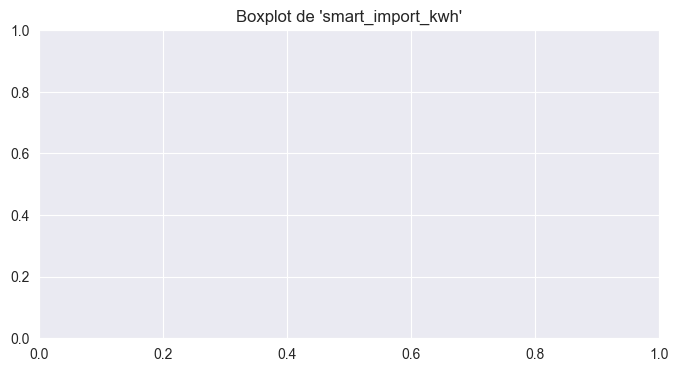

Columna 'billed_consumption_kwh': 0 outliers


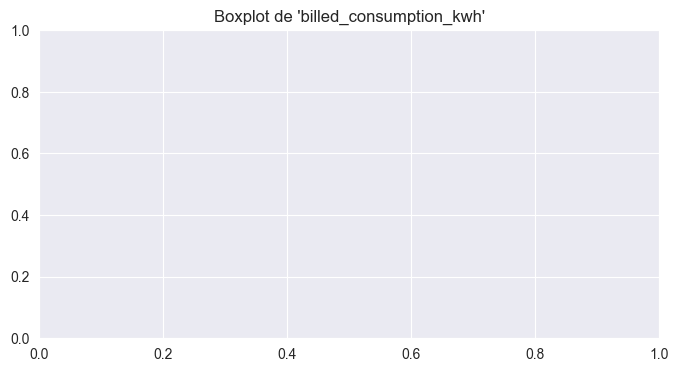

Columna 'phaseA_voltage_mean': 0 outliers


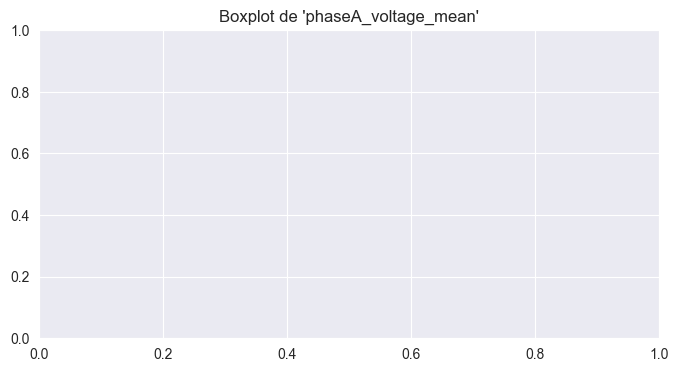

Columna 'Power Consumption (kWh)_iot_monthly': 0 outliers


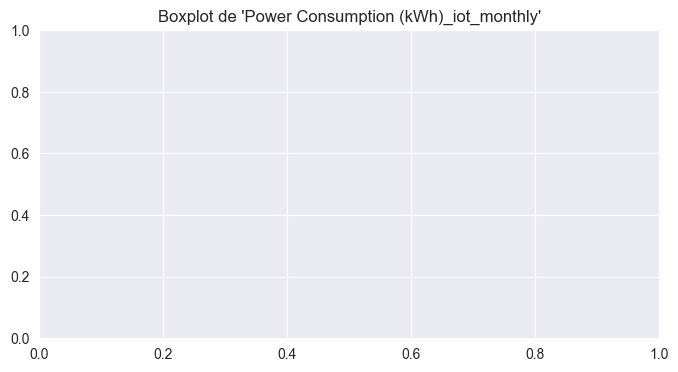

Columna 'use [kW]_iot_monthly': 0 outliers


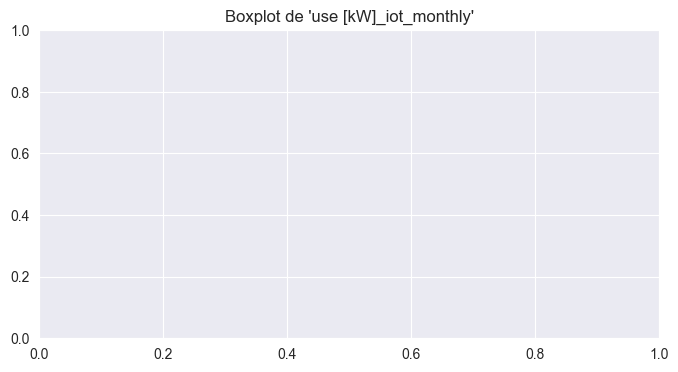

Columna 'gen [kW]_iot_monthly': 0 outliers


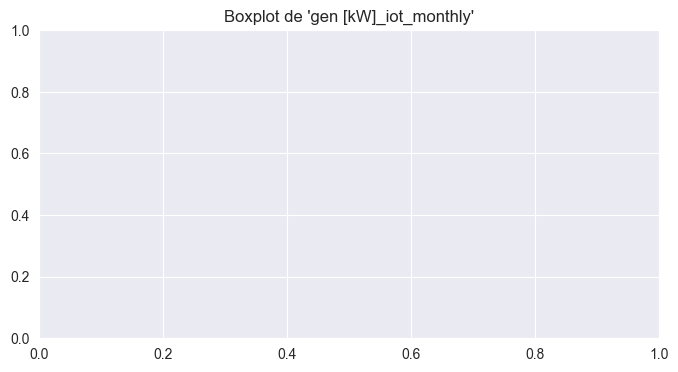

Columna 'House overall [kW]_iot_monthly': 0 outliers


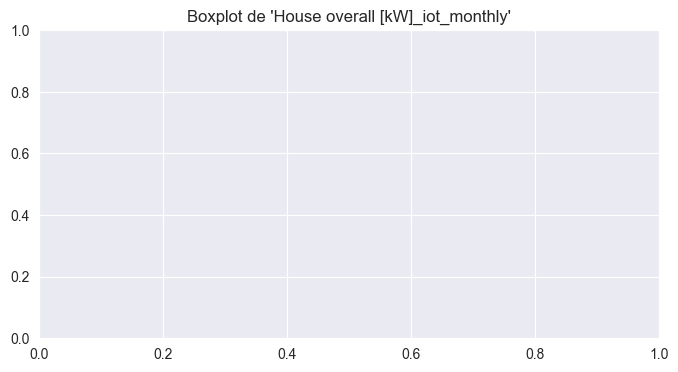

Columna 'Dishwasher [kW]_iot_monthly': 0 outliers


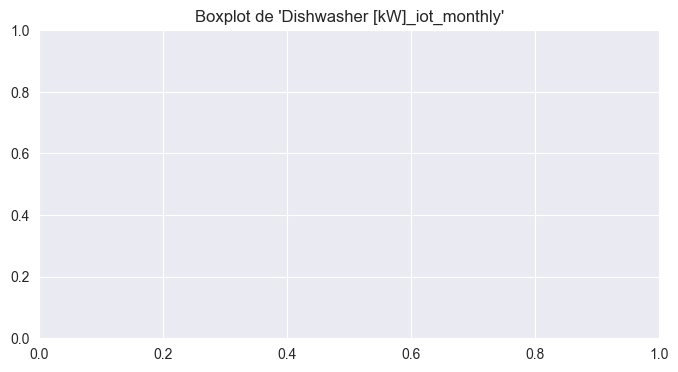

Columna 'Furnace 1 [kW]_iot_monthly': 0 outliers


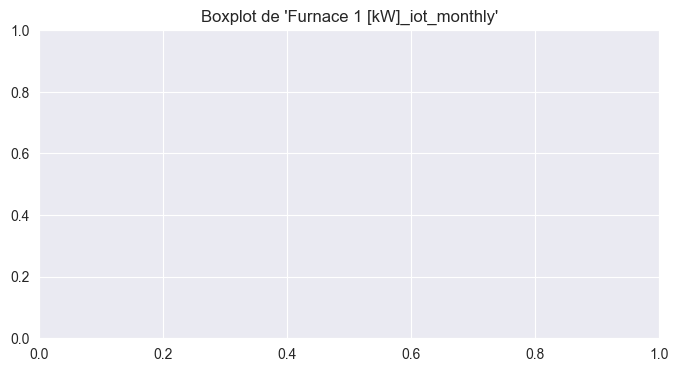

Columna 'Furnace 2 [kW]_iot_monthly': 0 outliers


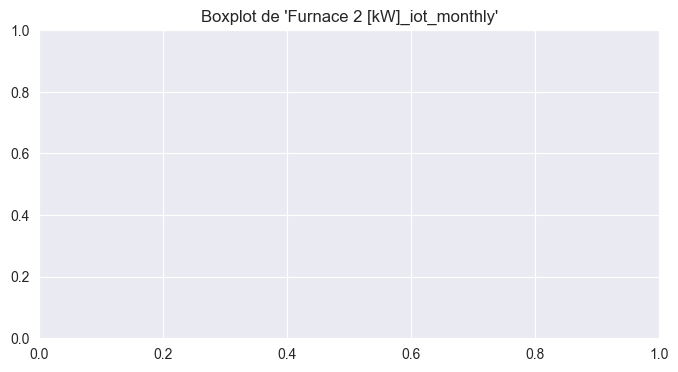

Columna 'Home office [kW]_iot_monthly': 0 outliers


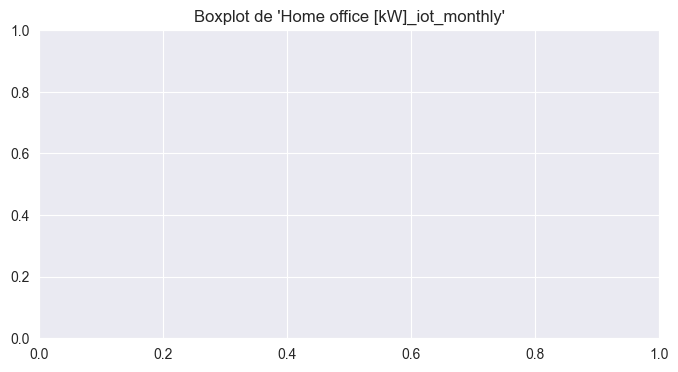

Columna 'Fridge [kW]_iot_monthly': 0 outliers


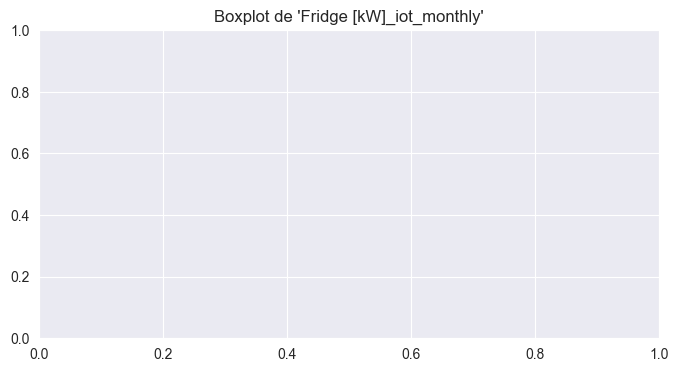

Columna 'Wine cellar [kW]_iot_monthly': 0 outliers


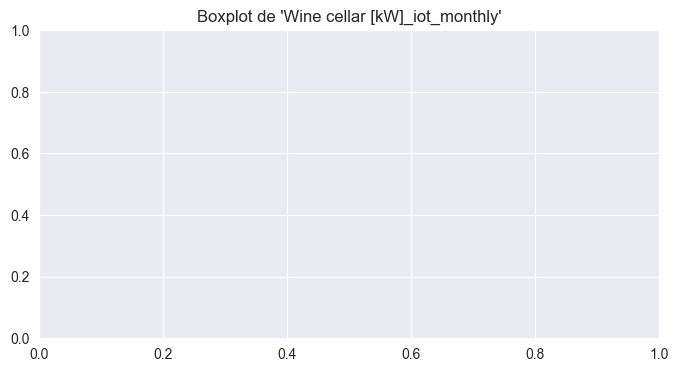

Columna 'Garage door [kW]_iot_monthly': 0 outliers


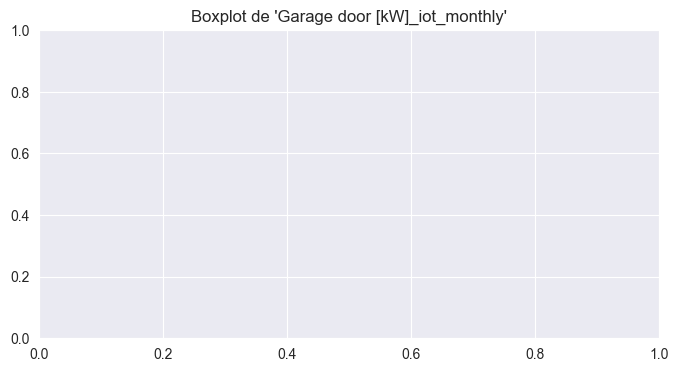

Columna 'Kitchen 12 [kW]_iot_monthly': 0 outliers


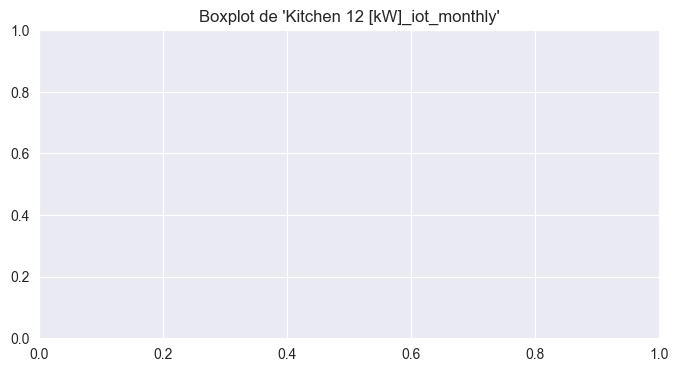

Columna 'Kitchen 14 [kW]_iot_monthly': 0 outliers


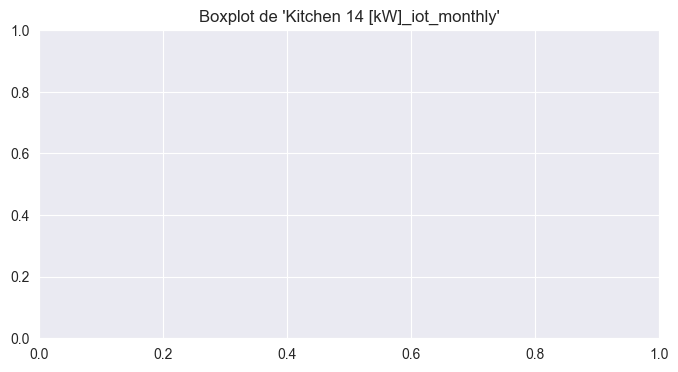

Columna 'Kitchen 38 [kW]_iot_monthly': 0 outliers


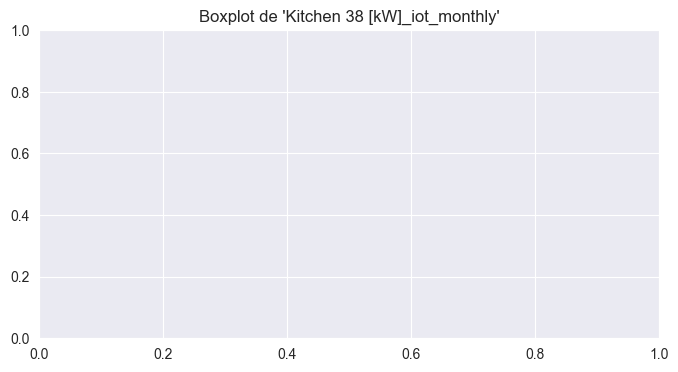

Columna 'Barn [kW]_iot_monthly': 0 outliers


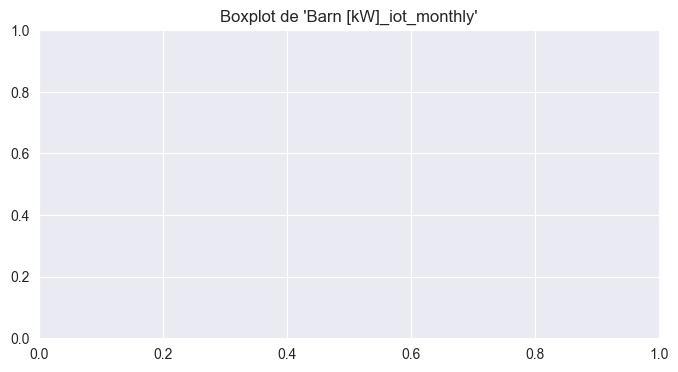

Columna 'Well [kW]_iot_monthly': 0 outliers


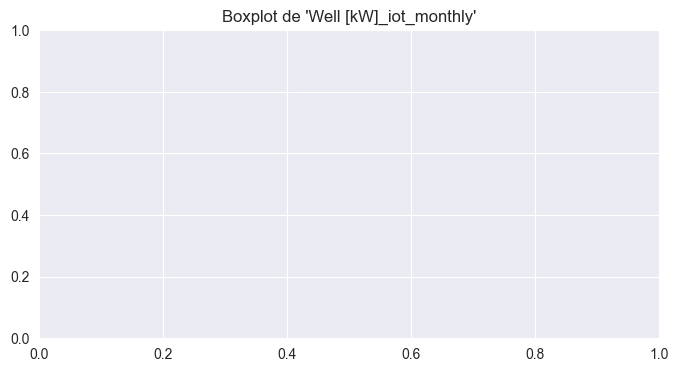

Columna 'Microwave [kW]_iot_monthly': 0 outliers


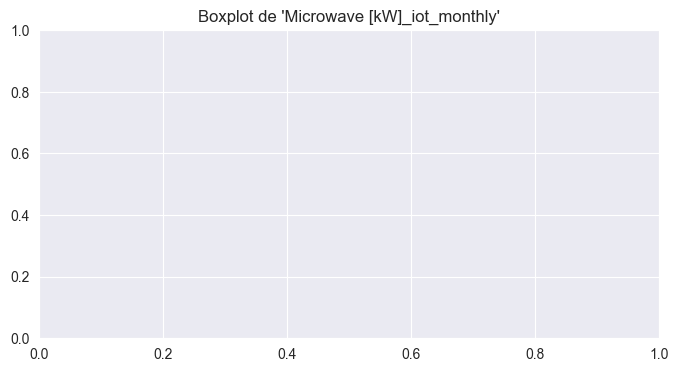

Columna 'Living room [kW]_iot_monthly': 0 outliers


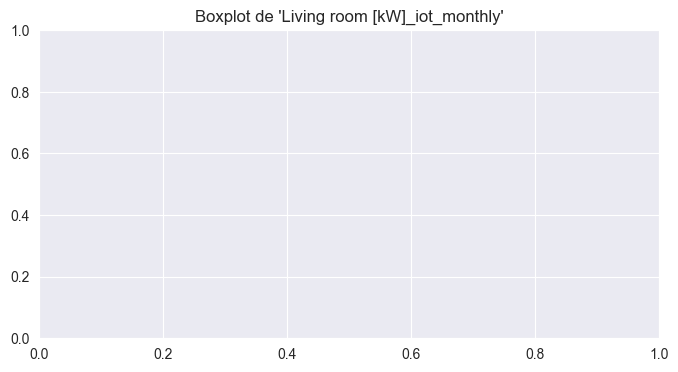

Columna 'Solar [kW]_iot_monthly': 0 outliers


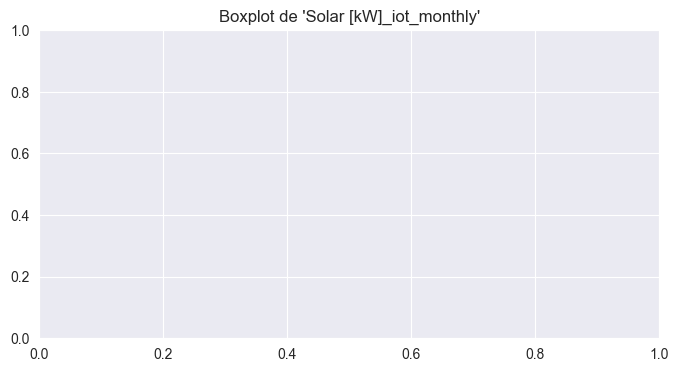

Columna 'Ventilador_iot_monthly': 0 outliers


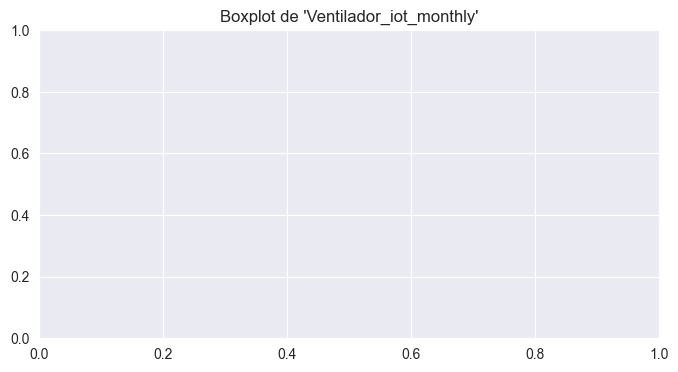

Columna 'PC_iot_monthly': 0 outliers


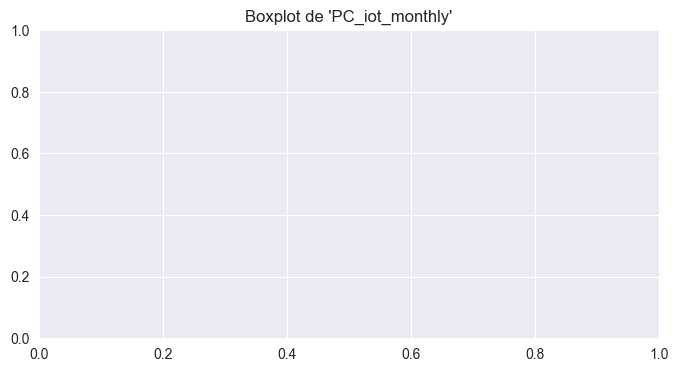

Columna 'AC_iot_monthly': 0 outliers


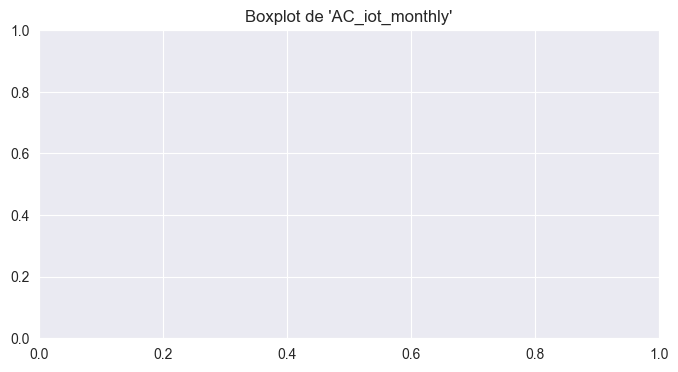

Columna 'Lampara_iot_monthly': 0 outliers


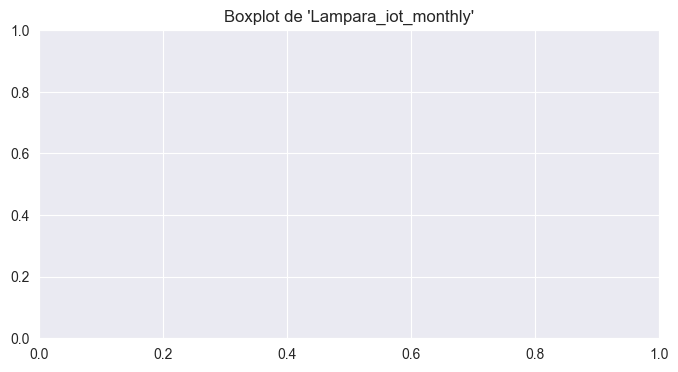

Columna 'TV_iot_monthly': 0 outliers


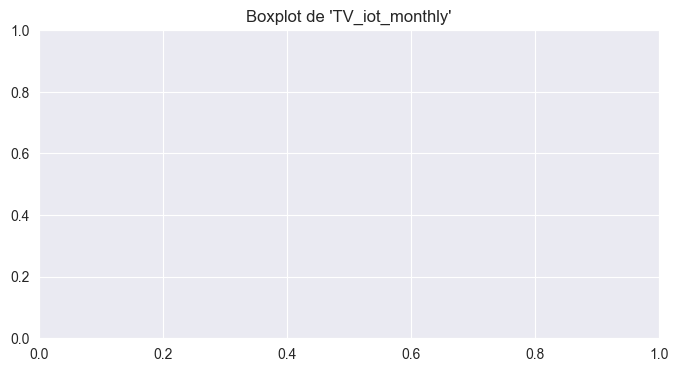

Columna 'n_ac_units_x': 1525 outliers


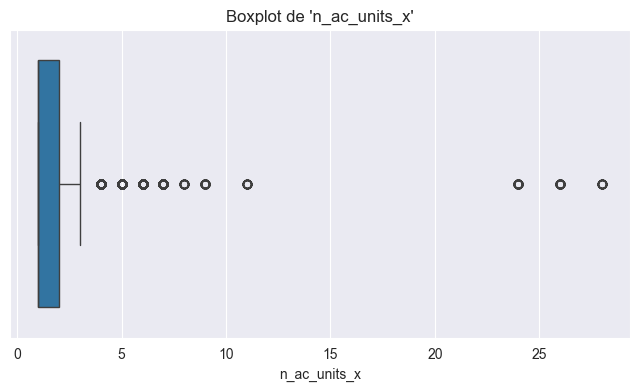

Columna 'ac_wattage_mean': 1675 outliers


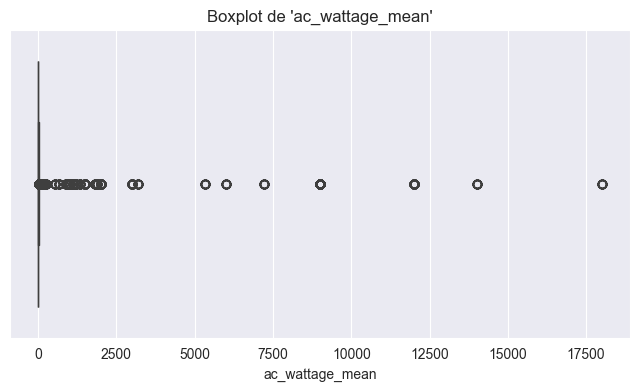

Columna 'ac_hours_last_week': 900 outliers


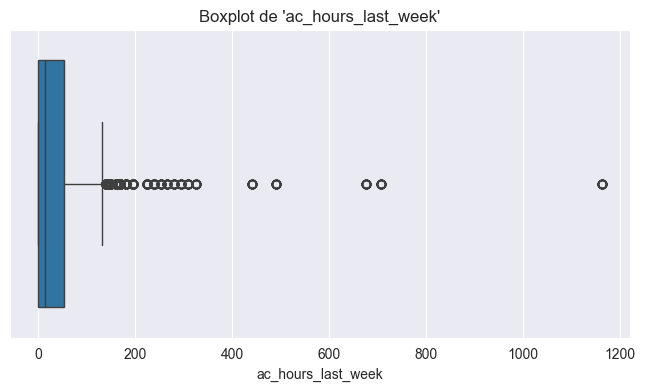

Columna 'n_appliances': 3775 outliers


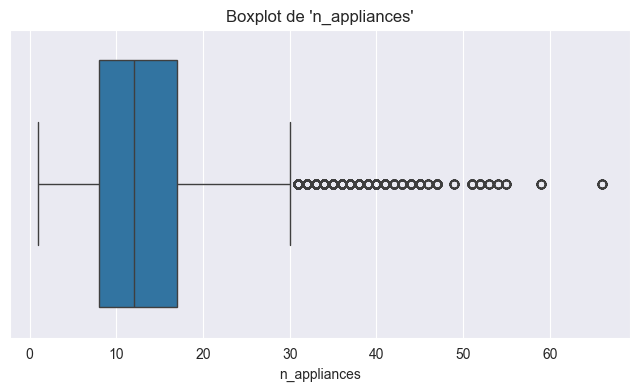

Columna 'appliances_hours_last_week': 13375 outliers


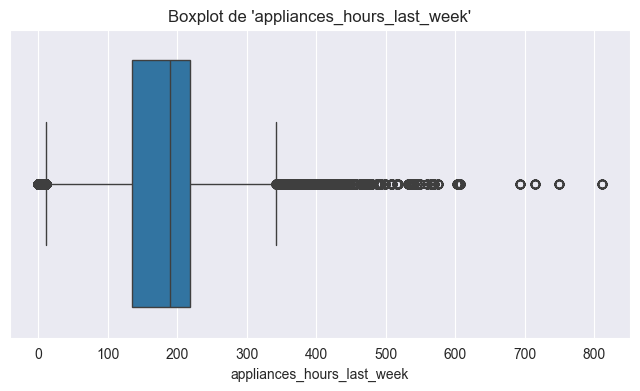

Columna 'n_fans_x': 5500 outliers


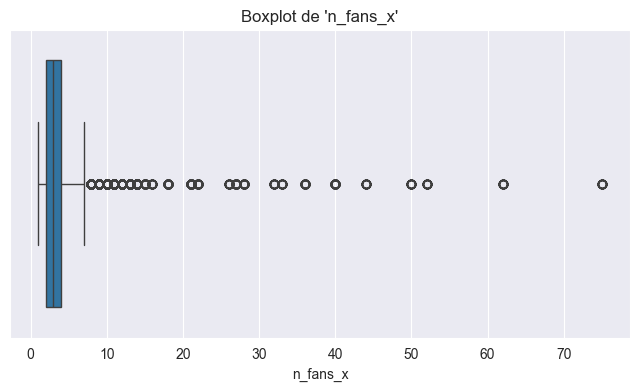

Columna 'fan_hours_last_week': 2875 outliers


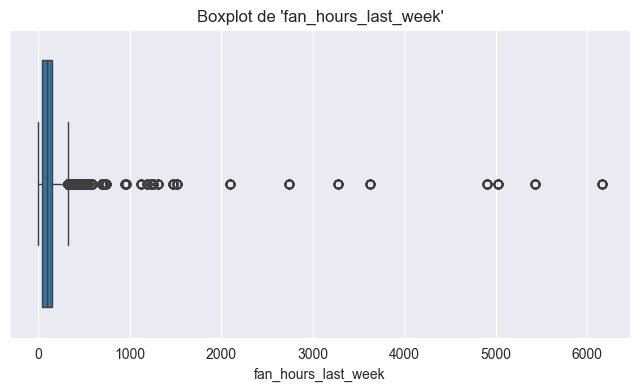

Columna 'n_bulbs_x': 8675 outliers


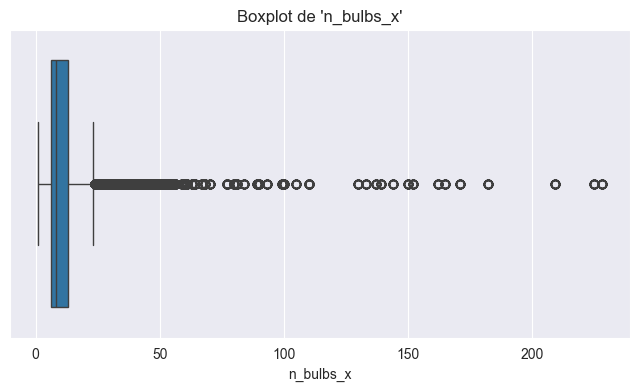

Columna 'bulbs_hours_last_week': 6175 outliers


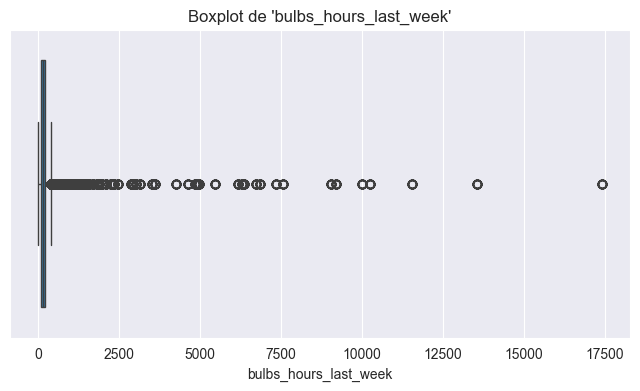

Columna 'household_size': 1375 outliers


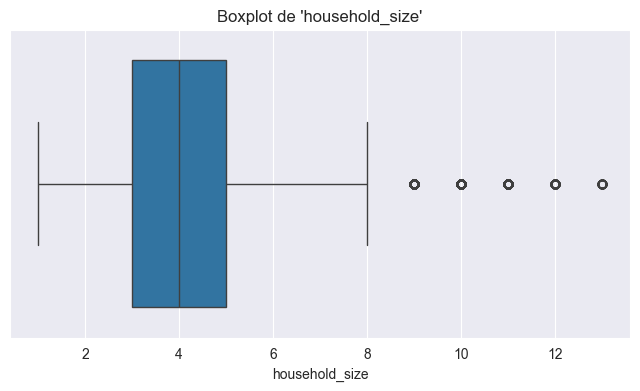

Columna 'hh_hours_at_home': 3325 outliers


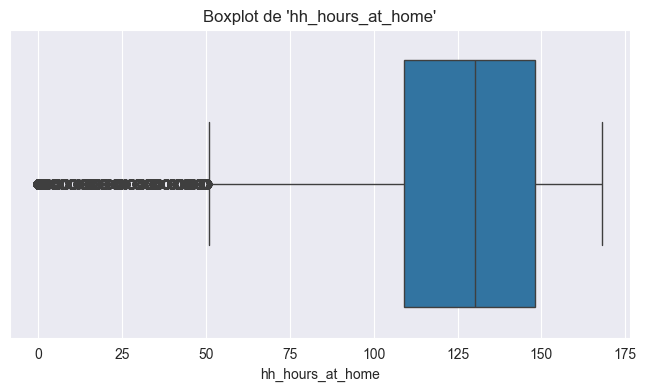

Columna 'n_ac_units_y': 1200 outliers


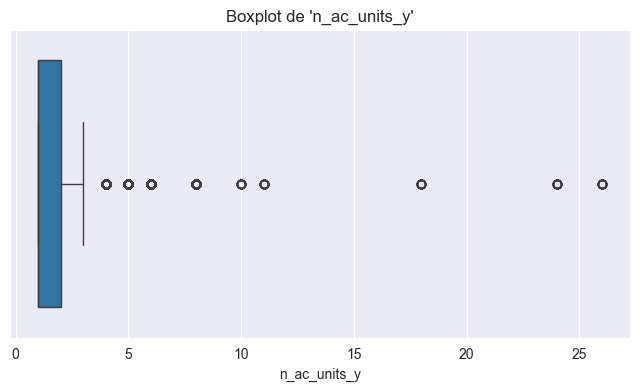

Columna 'ac_btu_mean': 25 outliers


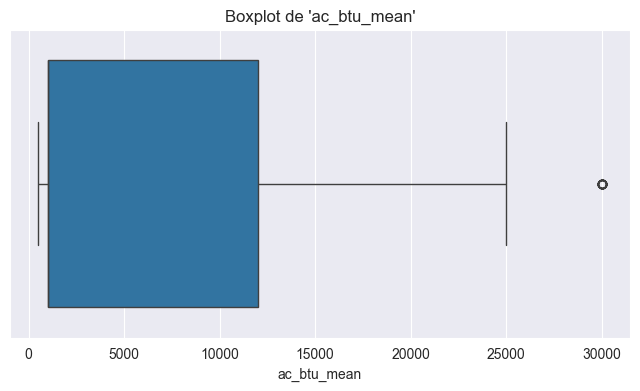

Columna 'ac_hours_lastw': 600 outliers


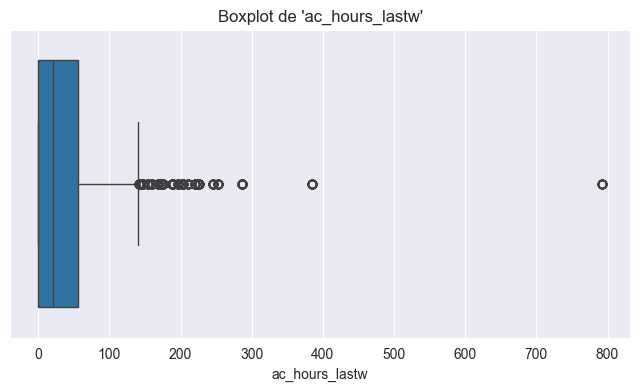

Columna 'n_app_types': 2625 outliers


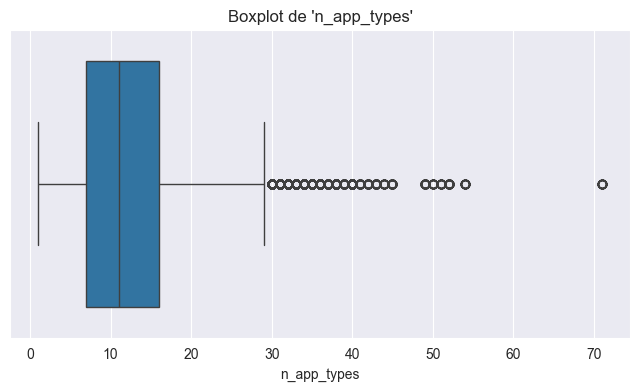

Columna 'app_hours_lastw': 3900 outliers


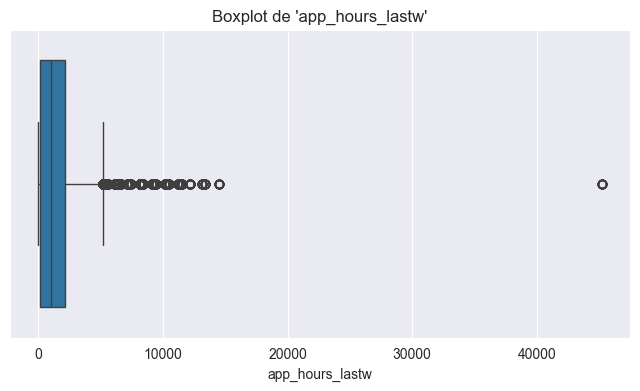

Columna 'appliances_w1': 3800 outliers


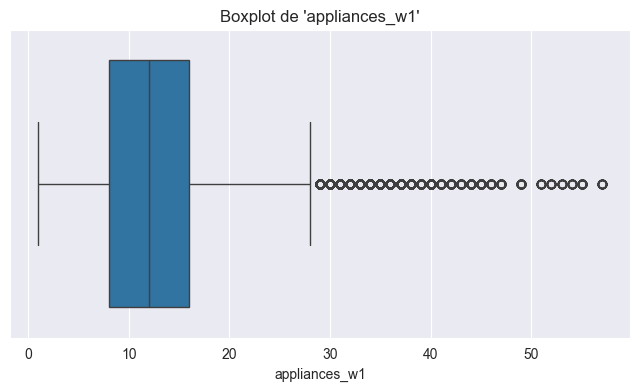

Columna 'new_appliances': 10325 outliers


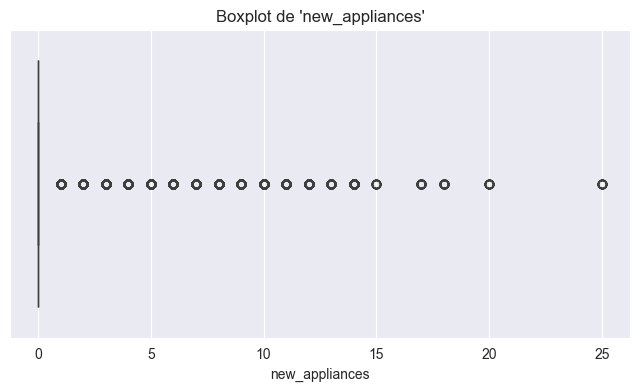

Columna 'rooms_w1': 3150 outliers


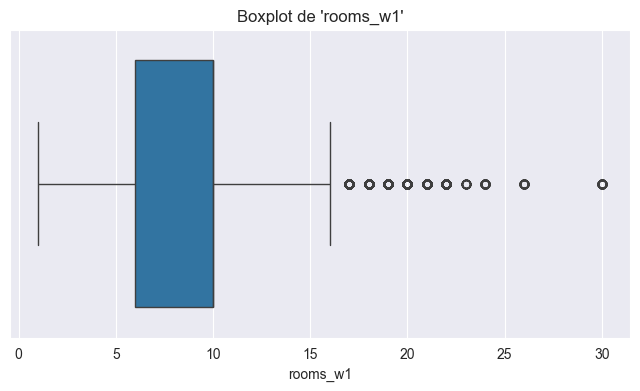

Columna 'rooms_changed': 3775 outliers


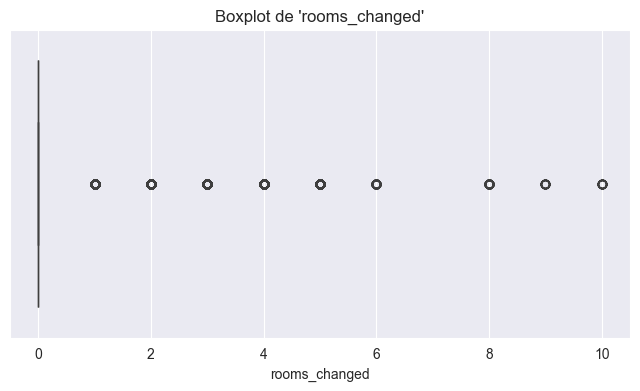

Columna 'units_solar_lastm': 3000 outliers


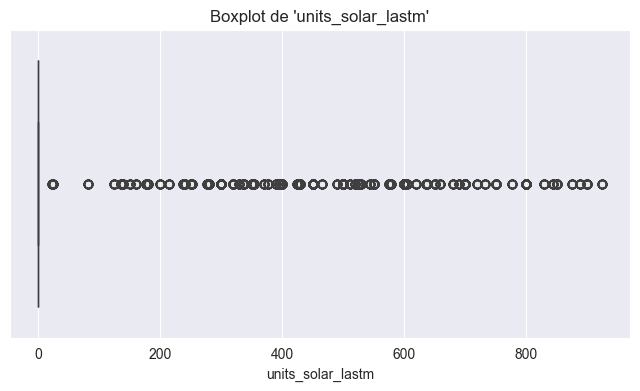

Columna 'capacity_solar': 1500 outliers


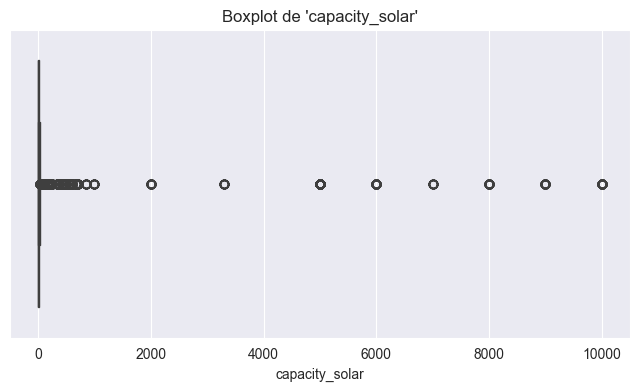

Columna 'n_fans_y': 3400 outliers


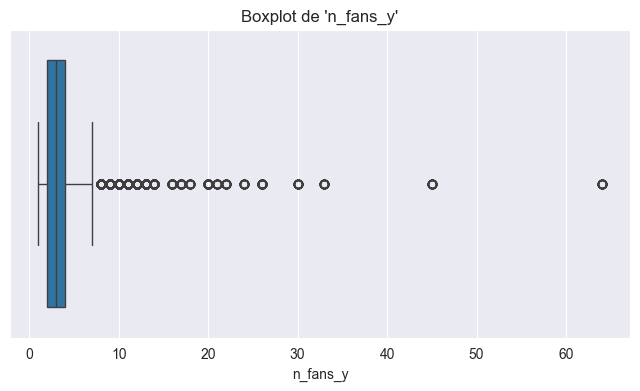

Columna 'fan_hours_lastw': 2125 outliers


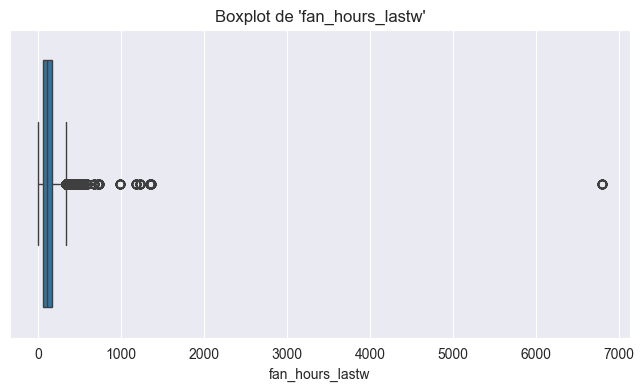

Columna 'new_household_members': 9075 outliers


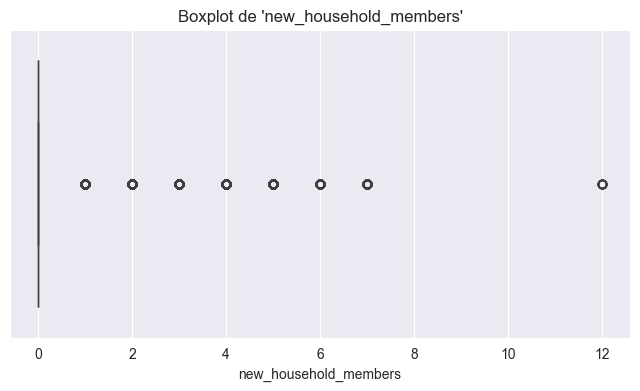

Columna 'n_bulbs_y': 3875 outliers


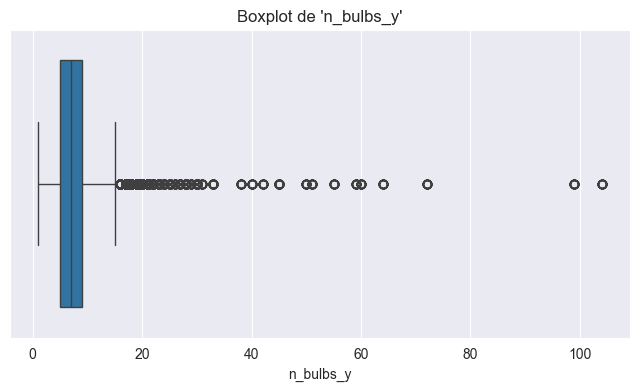

Columna 'bulb_hours_lastw': 4400 outliers


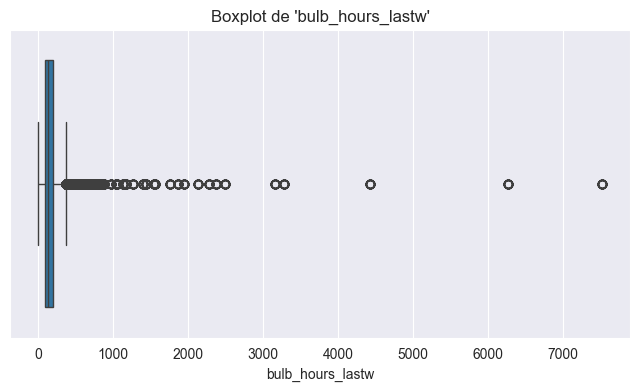

Columna 'still_in_house': 0 outliers


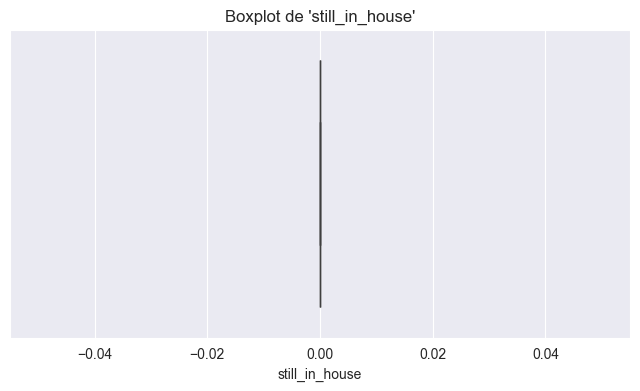

Columna 'new_activity_changes': 600 outliers


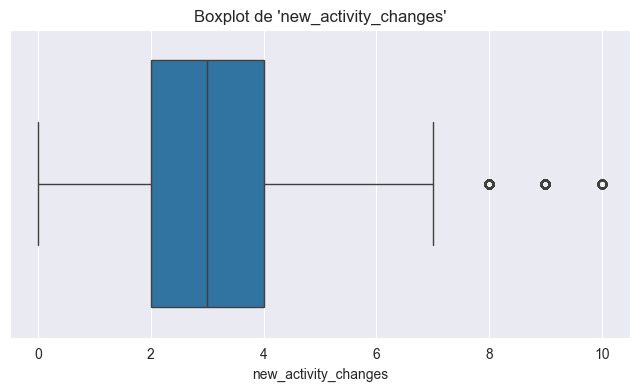

Columna 'hh_hours_at_home_new': 2425 outliers


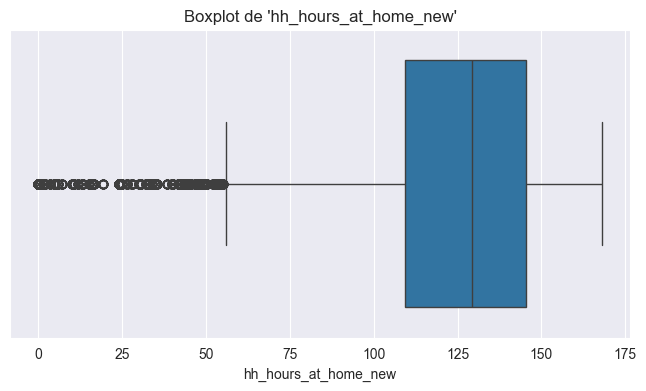

Columna 'n_new_members_x': 1100 outliers


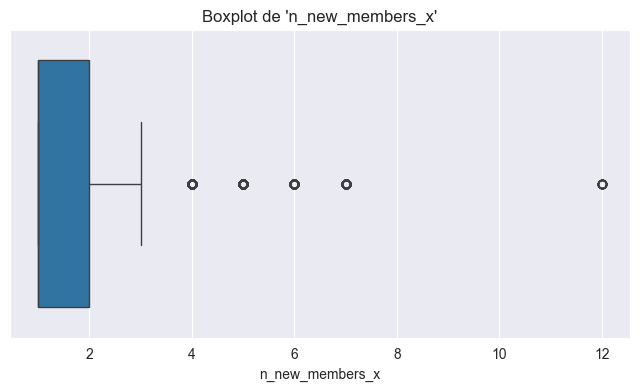

Columna 'age_new_mean_x': 0 outliers


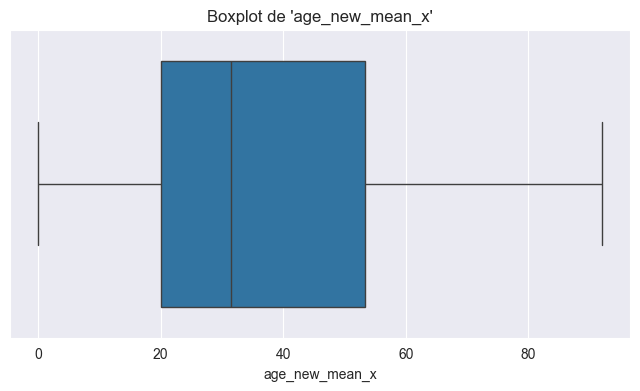

Columna 'hours_home_new_x': 0 outliers


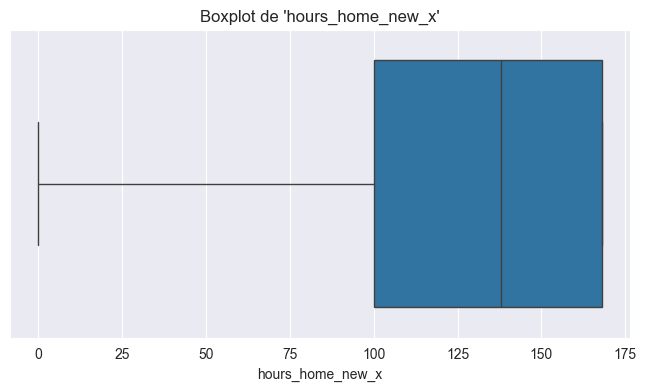

Columna 'n_rooms_x': 3275 outliers


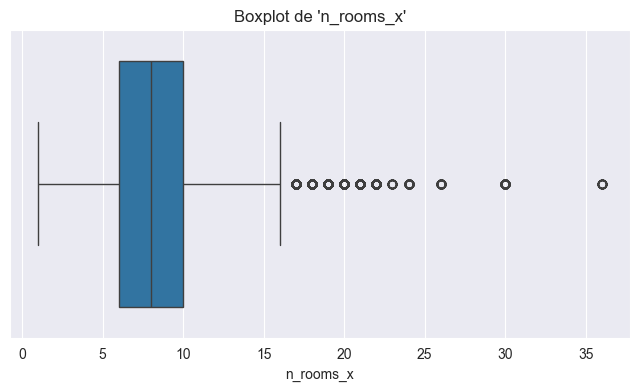

Columna 'windows_total_x': 8750 outliers


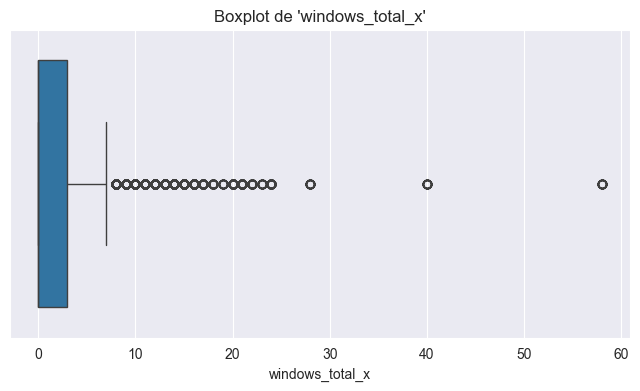

Columna 'fans_in_rooms_x': 3300 outliers


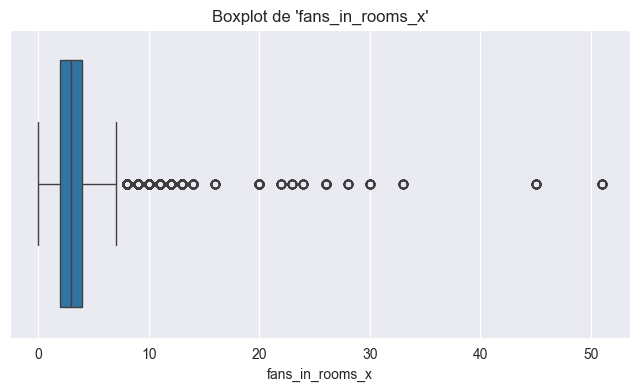

Columna 'ac_in_rooms_x': 10400 outliers


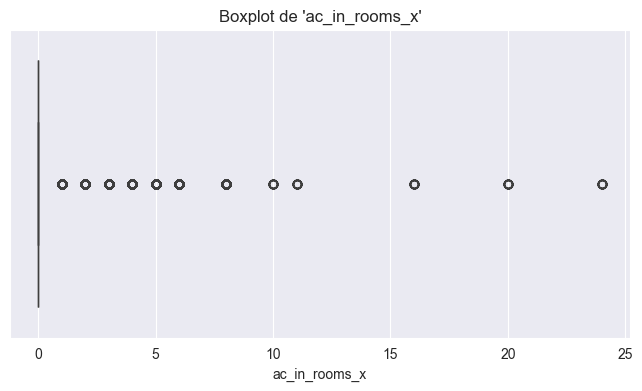

Columna 'bulbs_last_week_x': 4525 outliers


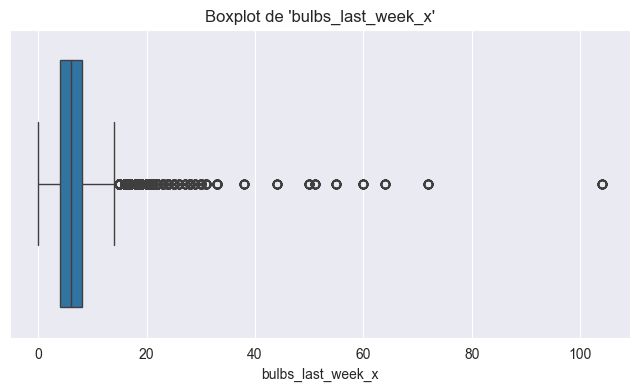

Columna 'n_new_members_y': 1100 outliers


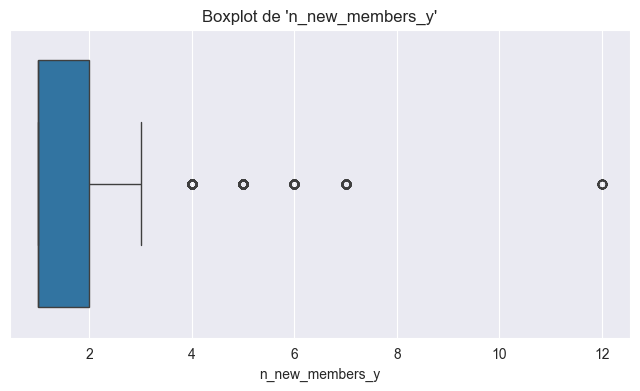

Columna 'age_new_mean_y': 0 outliers


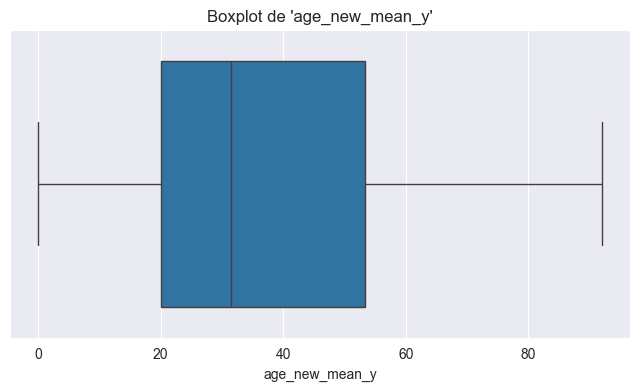

Columna 'hours_home_new_y': 0 outliers


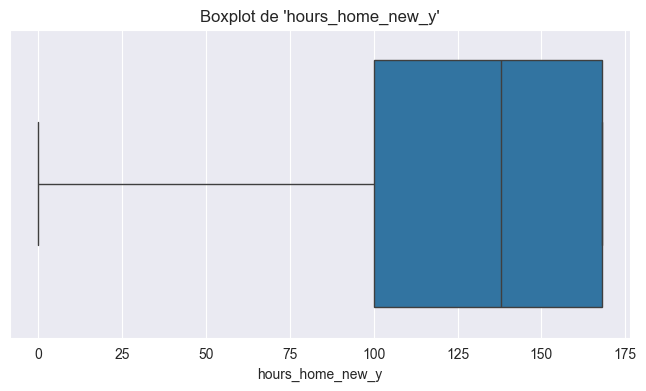

Columna 'n_rooms_y': 3275 outliers


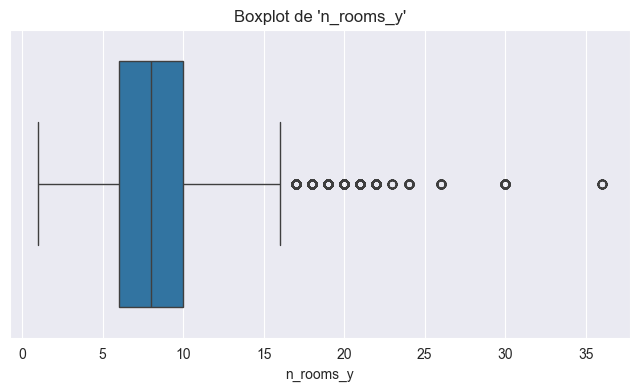

Columna 'windows_total_y': 8750 outliers


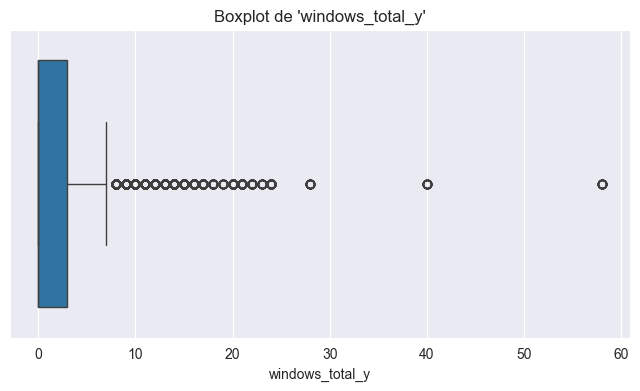

Columna 'fans_in_rooms_y': 3300 outliers


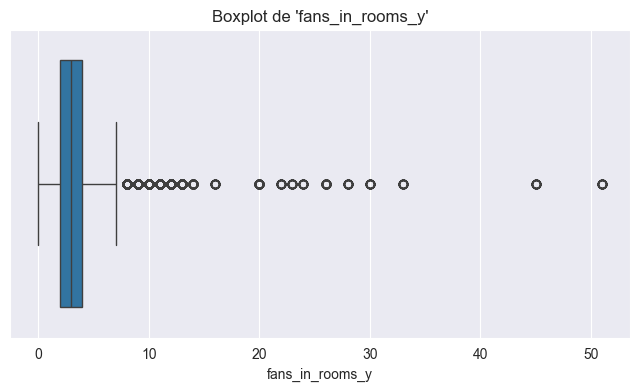

Columna 'ac_in_rooms_y': 10400 outliers


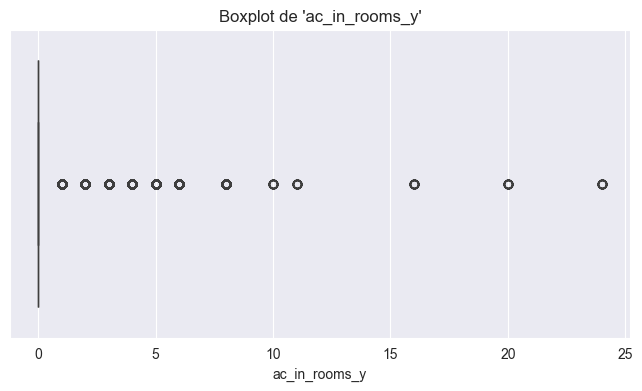

Columna 'bulbs_last_week_y': 4525 outliers


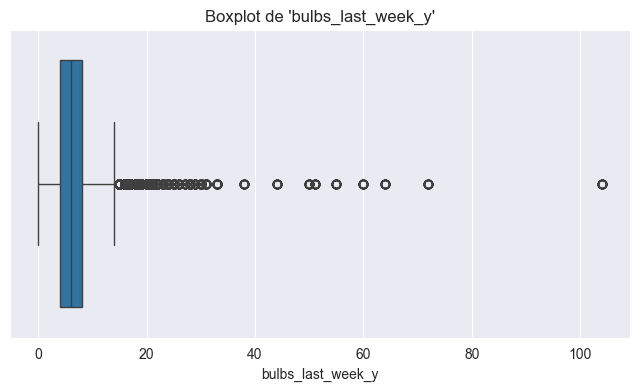

In [60]:
numeric_columns = df_final3.select_dtypes(include='number').columns

for col in numeric_columns:
    data = df_final3[col].dropna()
    Q1, Q3 = data.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lb, ub = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outliers = data[(data < lb) | (data > ub)]
    print(f"Columna '{col}': {len(outliers)} outliers")
    
    plt.figure(figsize=(8,4))
    # usa directamente data; Seaborn posiciona la caja sola
    sns.boxplot(x=data)  
    plt.title(f"Boxplot de '{col}'")
    plt.show()

**Paso 7. Calcular las estadísticas:**

In [61]:
df_final3.describe()

smart_import_kwh  billed_consumption_kwh  phaseA_voltage_mean  \
count               0.0                     0.0                  0.0   
mean                NaN                     NaN                  NaN   
std                 NaN                     NaN                  NaN   
min                 NaN                     NaN                  NaN   
25%                 NaN                     NaN                  NaN   
50%                 NaN                     NaN                  NaN   
75%                 NaN                     NaN                  NaN   
max                 NaN                     NaN                  NaN   

       Power Consumption (kWh)_iot_monthly  use [kW]_iot_monthly  \
count                                  0.0                   0.0   
mean                                   NaN                   NaN   
std                                    NaN                   NaN   
min                                    NaN                   NaN   
25%                                    NaN                   NaN   
50%                                    NaN                   NaN   
75%                                    NaN                   NaN   
max                                    NaN                   NaN   

       gen [kW]_iot_monthly  House overall [kW]_iot_monthly  \
count                   0.0                             0.0   
mean                    NaN                             NaN   
std                     NaN                             NaN   
min                     NaN                             NaN   
25%                     NaN                             NaN   
50%                     NaN                             NaN   
75%                     NaN                             NaN   
max                     NaN                             NaN   

       Dishwasher [kW]_iot_monthly  Furnace 1 [kW]_iot_monthly  \
count                          0.0                         0.0   
mean                           NaN                         NaN   
std                            NaN                         NaN   
min                            NaN                         NaN   
25%                            NaN                         NaN   
50%                            NaN                         NaN   
75%                            NaN                         NaN   
max                            NaN                         NaN   

       Furnace 2 [kW]_iot_monthly  ...  ac_in_rooms_x  bulbs_last_week_x  \
count                         0.0  ...   87475.000000       87475.000000   
mean                          NaN  ...       0.242355           6.953129   
std                           NaN  ...       0.985537           4.912707   
min                           NaN  ...       0.000000           0.000000   
25%                           NaN  ...       0.000000           4.000000   
50%                           NaN  ...       0.000000           6.000000   
75%                           NaN  ...       0.000000           8.000000   
max                           NaN  ...      24.000000         104.000000   

       n_new_members_y  age_new_mean_y  hours_home_new_y     n_rooms_y  \
count      9075.000000     9075.000000       9075.000000  87475.000000   
mean          1.950413       35.198524        126.717982      8.343241   
std           1.389834       22.494003         43.611009      3.643490   
min           1.000000        0.000000          0.000000      1.000000   
25%           1.000000       20.000000        100.000000      6.000000   
50%           1.000000       31.500000        138.000000      8.000000   
75%           2.000000       53.333333        168.000000     10.000000   
max          12.000000       92.000000        168.000000     36.000000   

       windows_total_y  fans_in_rooms_y  ac_in_rooms_y  bulbs_last_week_y  
count     87475.000000     87475.000000   87475.000000       87475.000000  
mean          2.048300         3.108031       0.242355           6.953129  
st

In [62]:
df_final3.describe(include=['object'])

household_ID       month monthly_consumption_kwh smart6h_import_kwh  \
count        101575      101575                  100985                  0   
unique         4063          25                    1134                  0   
top          ID4063  2022-10-31                       0                NaN   
freq             25        4063                    2332                NaN   

       type_of_electricity_meter socio_economic_class  \
count                     101575               101575   
unique                         2                    5   
top                  Smart meter                SEC C   
freq                       54650                37125   

       1. We iron the clothes weekly. 2. We iron our clothes twice a week.  \
count                           87475                                87475   
unique                              2                                    2   
top                             False                                False   
freq                            78675                                75900   

       3. We iron the clothes daily.  \
count                          87475   
unique                             2   
top                            False   
freq                           59150   

       4. We iron when and where the need arises.  ... 2. Sometimes 3. Never  \
count                                       87475  ...        87475    87475   
unique                                          2  ...            2        2   
top                                         False  ...        False    False   
freq                                        57850  ...        72300    84975   

       1. Very conscious 2. Somewhat conscious 3. Not conscious at all     No  \
count              87475                 87475                   87475  87475   
unique                 2                     2                       2      2   
top                 True                 False                   False  False   
freq               65025                 70450                   82050  77000   

          Yes had_solar new_electricity_meters  \
count   87475     87475                  87475   
unique      2         2                      2   
top      True        No                     No   
freq    77000     80125                  86450   

       smart_metered_or_non_smart_metered  
count                               87475  
unique                                  2  
top                           Smart meter  
freq                                48325  

[4 rows x 28 columns]

**Paso 8. Análisis de tendencia central, posición y dispersión:**

In [63]:
# Análisis de tendencia central: mediana y moda

# Mediana
mediana = df_final3.median(numeric_only=True)
mediana

smart_import_kwh                       NaN
billed_consumption_kwh                 NaN
phaseA_voltage_mean                    NaN
Power Consumption (kWh)_iot_monthly    NaN
use [kW]_iot_monthly                   NaN
                                      ... 
w2_12/09/2024                          0.0
w2_12/10/2024                          0.0
w2_12/12/2024                          0.0
w2_12/15/2024                          0.0
w2_12/17/2024                          0.0
Length: 286, dtype: float64

In [64]:
# Moda
moda = df_final3.mode().iloc[0]
moda

household_ID                   ID0001
month                      2022-10-31
monthly_consumption_kwh             0
smart_import_kwh                  NaN
billed_consumption_kwh            NaN
                              ...    
w2_12/09/2024                   False
w2_12/10/2024                   False
w2_12/12/2024                   False
w2_12/15/2024                   False
w2_12/17/2024                   False
Name: 0, Length: 314, dtype: object

In [65]:
# Medidas de dispersión: varianza y desviación estándar
# Varianza
df_final3.var(numeric_only=True)

smart_import_kwh                            NaN
billed_consumption_kwh                      NaN
phaseA_voltage_mean                         NaN
Power Consumption (kWh)_iot_monthly         NaN
use [kW]_iot_monthly                        NaN
                                         ...   
w2_12/09/2024                          0.000738
w2_12/10/2024                          0.000246
w2_12/12/2024                          0.000246
w2_12/15/2024                          0.000492
w2_12/17/2024                          0.000246
Length: 286, dtype: float64

In [66]:
# Desviación estándar
df_final3.std(numeric_only=True)

smart_import_kwh                            NaN
billed_consumption_kwh                      NaN
phaseA_voltage_mean                         NaN
Power Consumption (kWh)_iot_monthly         NaN
use [kW]_iot_monthly                        NaN
                                         ...   
w2_12/09/2024                          0.027163
w2_12/10/2024                          0.015686
w2_12/12/2024                          0.015686
w2_12/15/2024                          0.022181
w2_12/17/2024                          0.015686
Length: 286, dtype: float64

In [67]:
# Análisis de posición: percentiles e IQR
df_final3.select_dtypes(include='number').quantile([0.25, 0.5, 0.75])

smart_import_kwh  billed_consumption_kwh  phaseA_voltage_mean  \
0.25               NaN                     NaN                  NaN   
0.50               NaN                     NaN                  NaN   
0.75               NaN                     NaN                  NaN   

      Power Consumption (kWh)_iot_monthly  use [kW]_iot_monthly  \
0.25                                  NaN                   NaN   
0.50                                  NaN                   NaN   
0.75                                  NaN                   NaN   

      gen [kW]_iot_monthly  House overall [kW]_iot_monthly  \
0.25                   NaN                             NaN   
0.50                   NaN                             NaN   
0.75                   NaN                             NaN   

      Dishwasher [kW]_iot_monthly  Furnace 1 [kW]_iot_monthly  \
0.25                          NaN                         NaN   
0.50                          NaN                         NaN   
0.75                          NaN                         NaN   

      Furnace 2 [kW]_iot_monthly  ...  ac_in_rooms_x  bulbs_last_week_x  \
0.25                         NaN  ...            0.0                4.0   
0.50                         NaN  ...            0.0                6.0   
0.75                         NaN  ...            0.0                8.0   

      n_new_members_y  age_new_mean_y  hours_home_new_y  n_rooms_y  \
0.25              1.0       20.000000             100.0        6.0   
0.50              1.0       31.500000             138.0        8.0   
0.75              2.0       53.333333             168.0       10.0   

      windows_total_y  fans_in_rooms_y  ac_in_rooms_y  bulbs_last_week_y  
0.25              0.0              2.0            0.0                4.0  
0.50              0.0              3.0            0.0                6.0  
0.75              3.0              4.0            0.0                8.0  

[3 rows x 73 columns]

In [68]:
# IQR
IQR = df_final3.select_dtypes(include='number').quantile(0.75) - df_final3.select_dtypes(include='number').quantile(0.25)
IQR

smart_import_kwh                       NaN
billed_consumption_kwh                 NaN
phaseA_voltage_mean                    NaN
Power Consumption (kWh)_iot_monthly    NaN
use [kW]_iot_monthly                   NaN
                                      ... 
n_rooms_y                              4.0
windows_total_y                        3.0
fans_in_rooms_y                        2.0
ac_in_rooms_y                          0.0
bulbs_last_week_y                      4.0
Length: 73, dtype: float64

**Paso 9. Contando datos duplicados:**

In [69]:
duplicates = df_final3.duplicated().sum()
duplicates

np.int64(0)

**Paso 10. Exploración y visualización de los datos**

**10.1. Análisis de variables numéricas:**

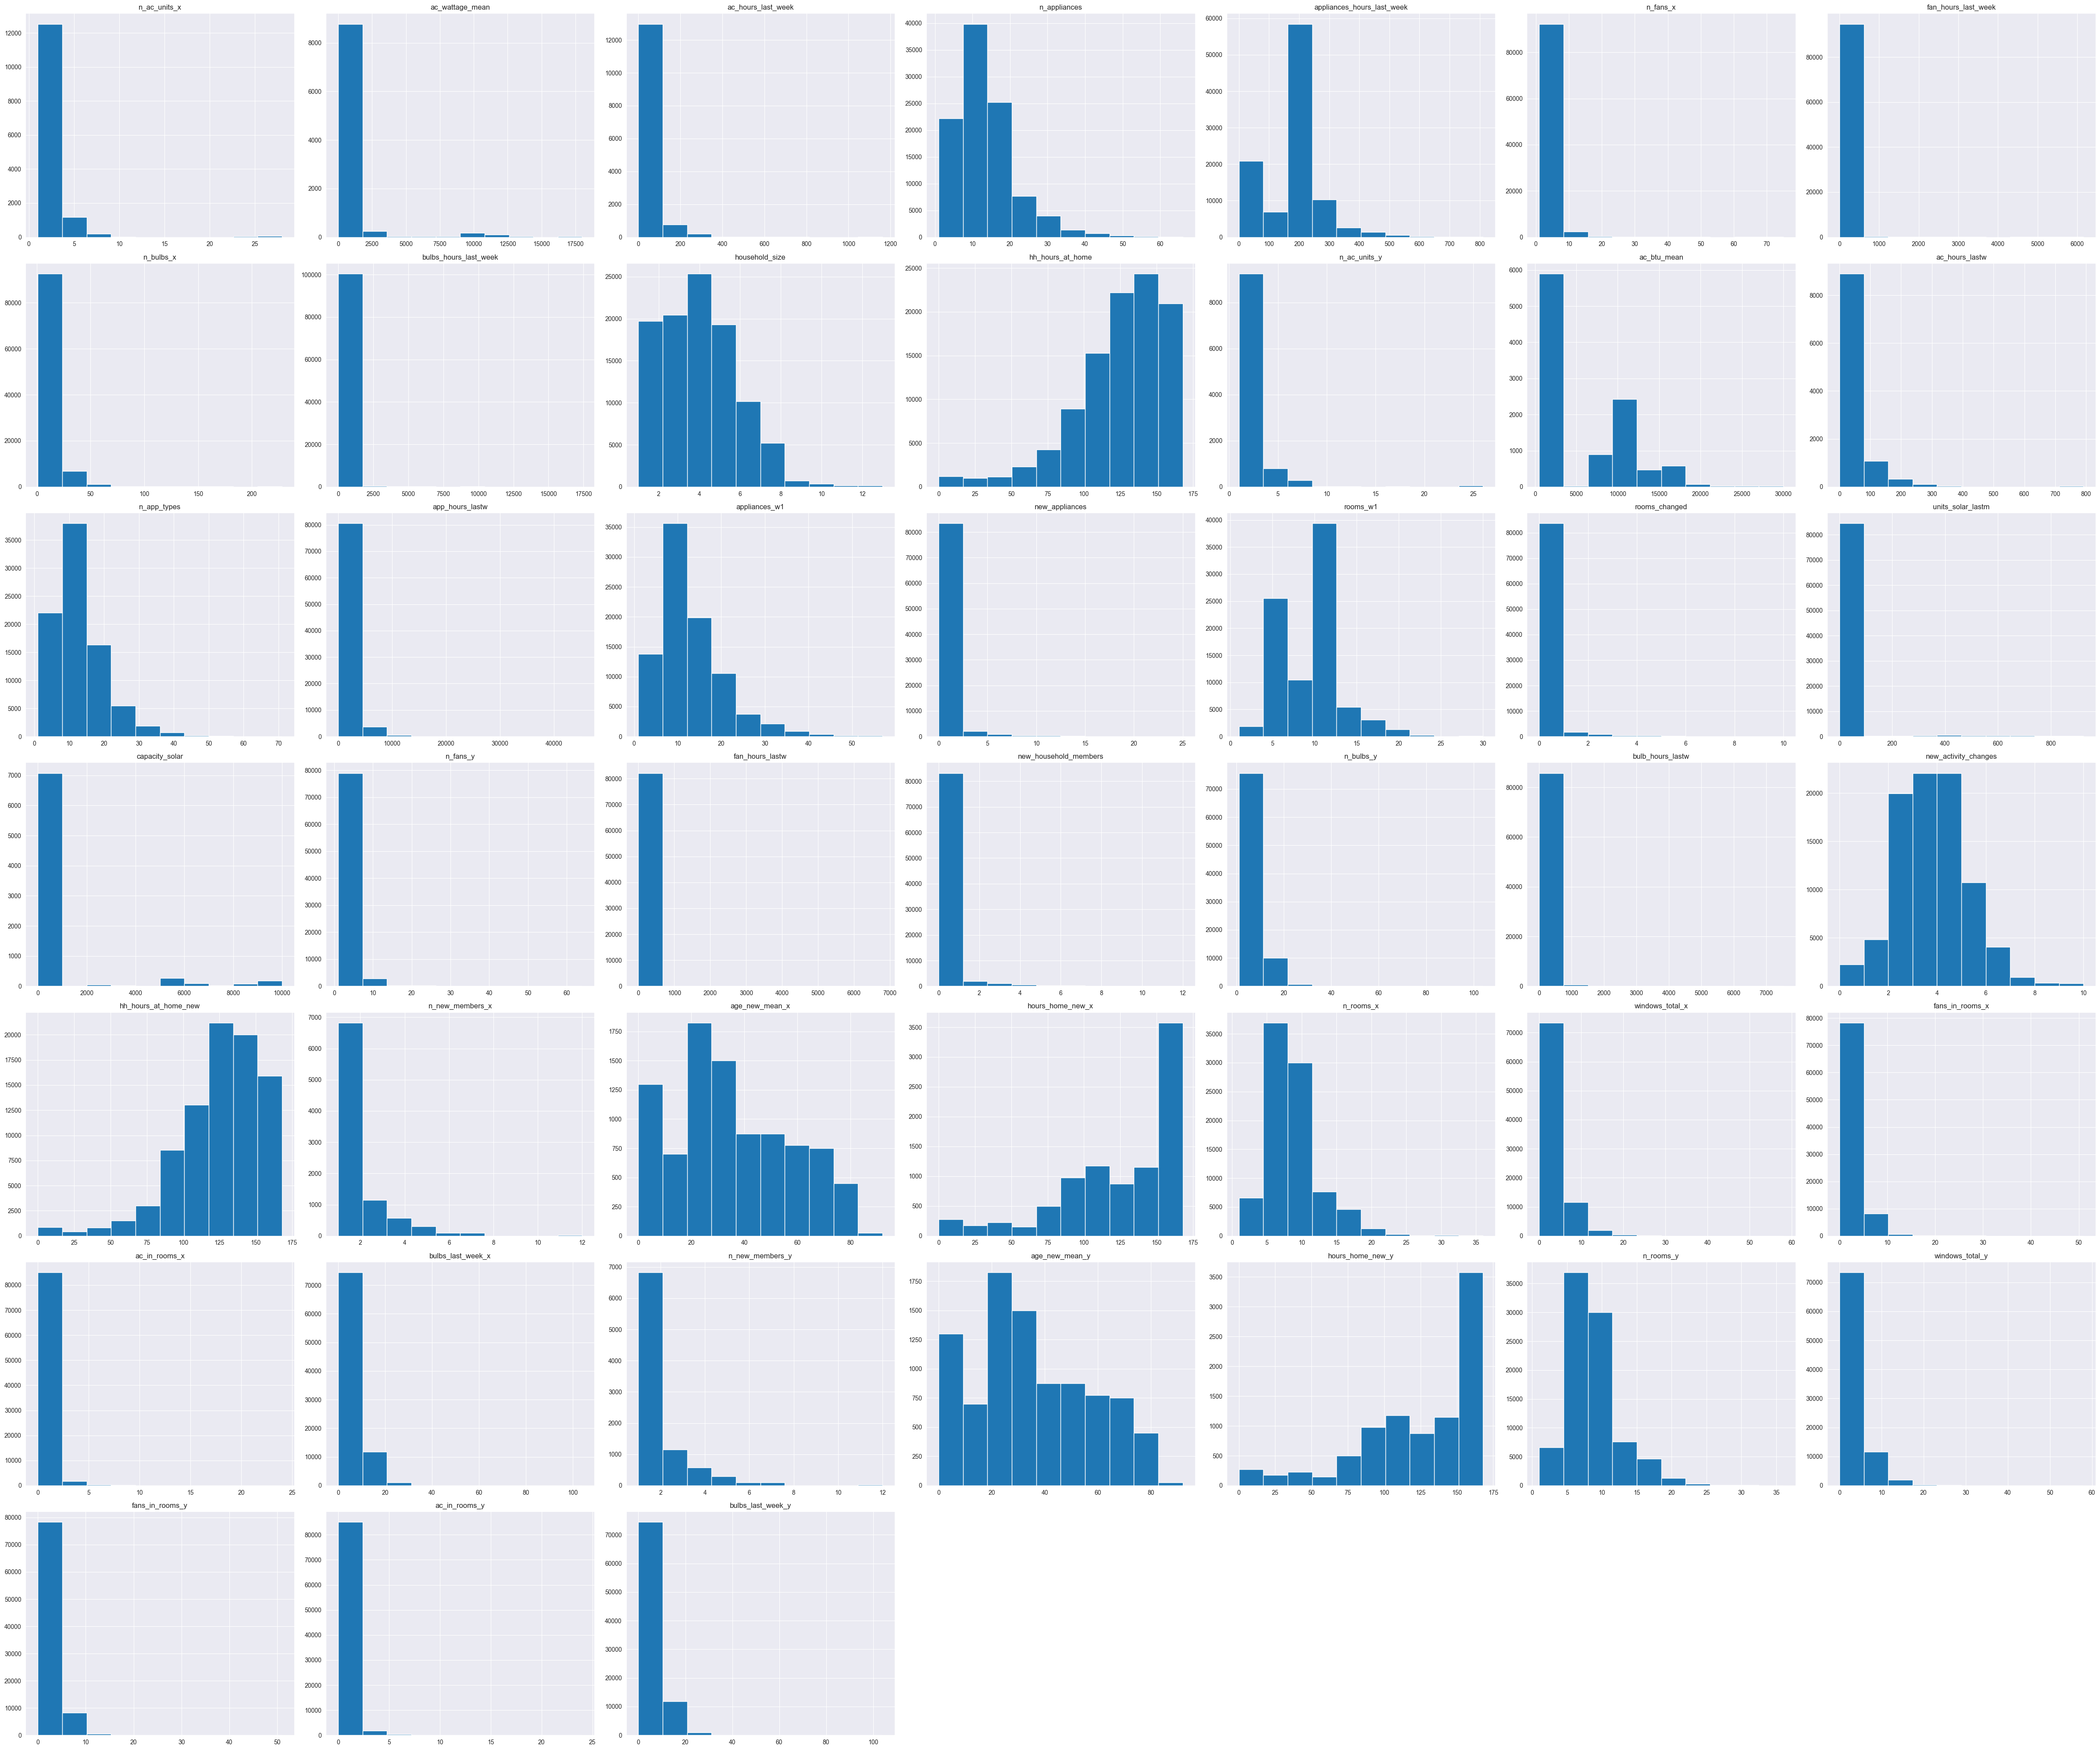

In [70]:
num = df_final3.select_dtypes(include='number')
num = num.dropna(axis=1, how='all')
cols_nonconstant = [c for c in num.columns if num[c].nunique(dropna=True) > 1]
num = num[cols_nonconstant]
num.hist(figsize=(48,40))
plt.tight_layout()
plt.show()

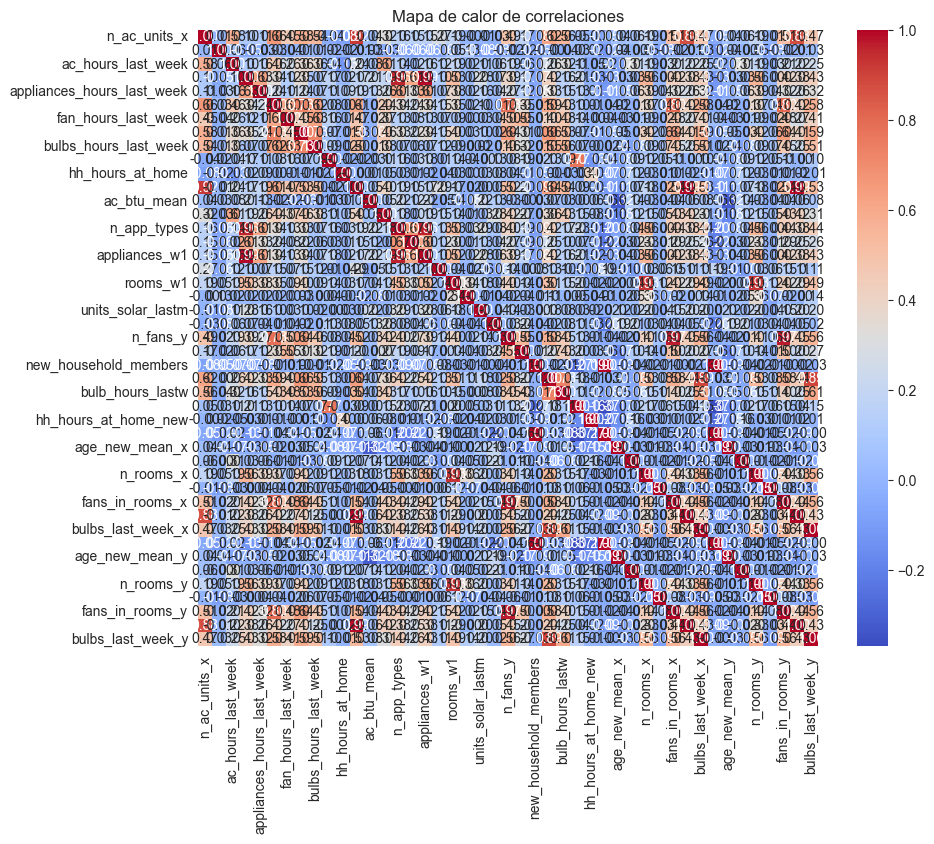

In [71]:
numeric_df = df_final3.select_dtypes(include=['number'])
numeric_df = numeric_df.dropna(axis=1, how='all')
numeric_df = numeric_df.loc[:, numeric_df.nunique(dropna=True) > 1]
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Mapa de calor de correlaciones")
plt.show()

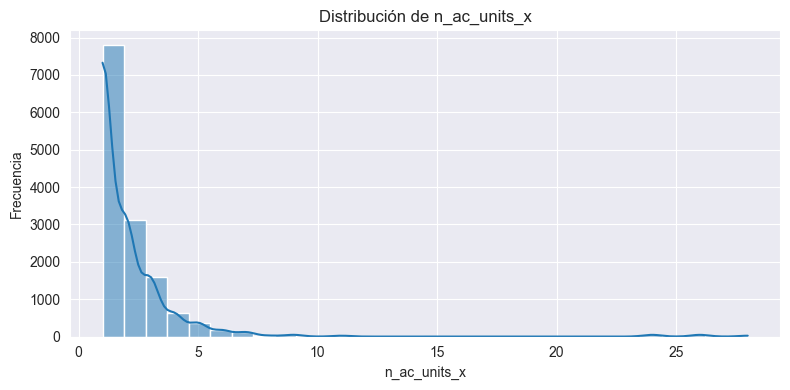

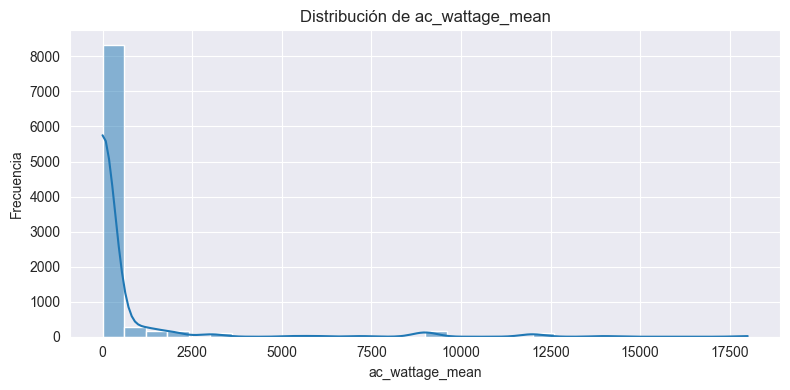

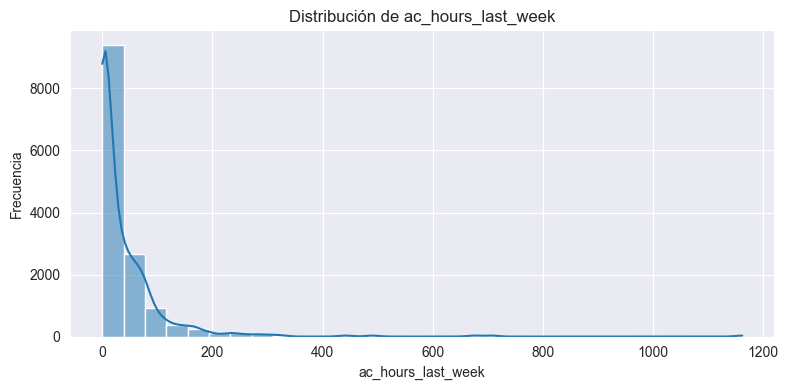

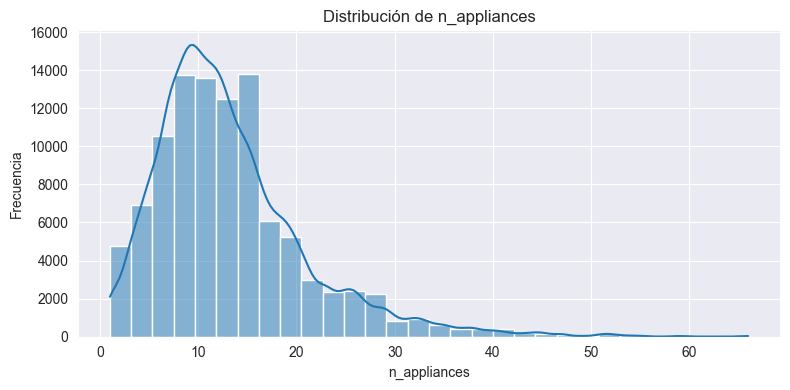

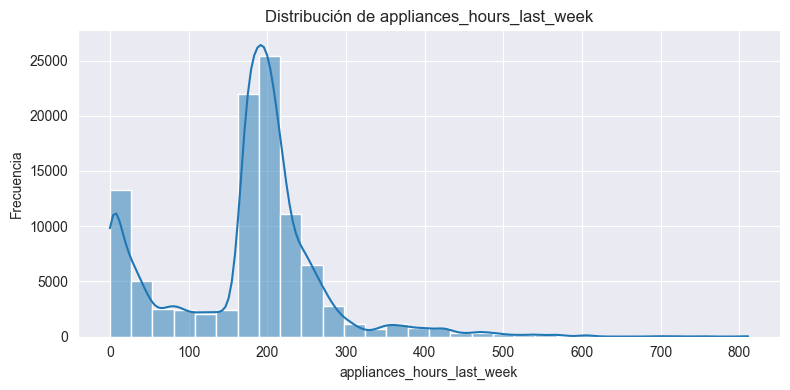

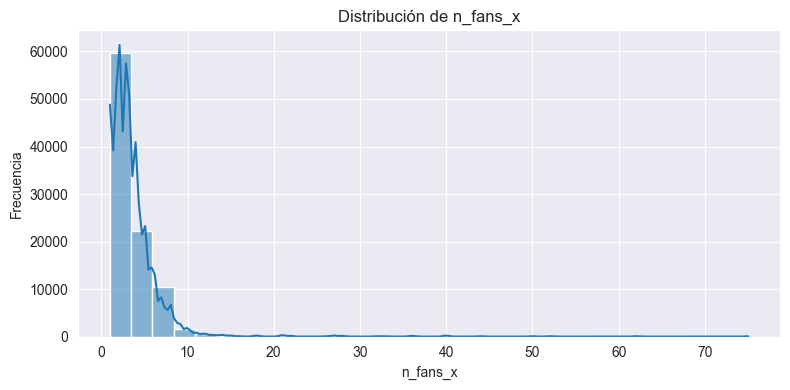

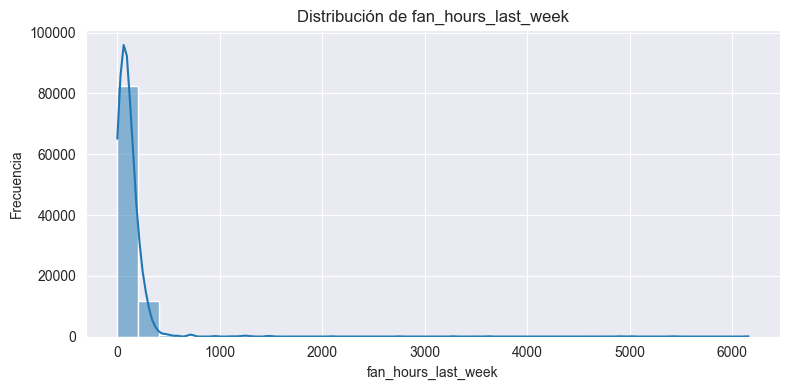

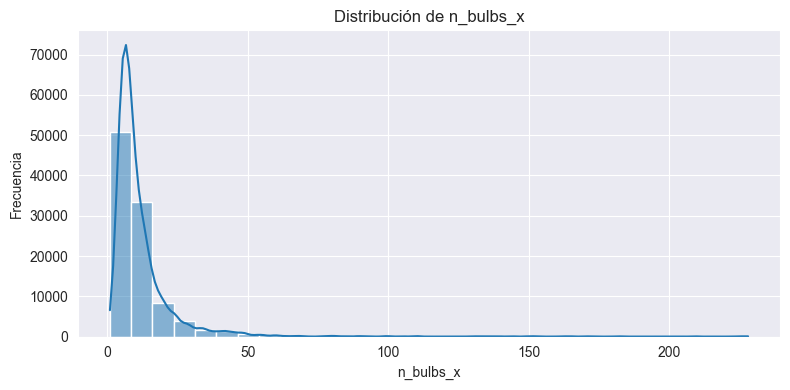

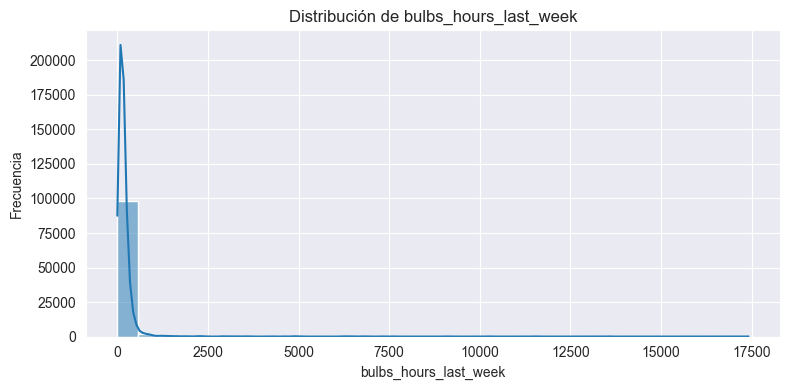

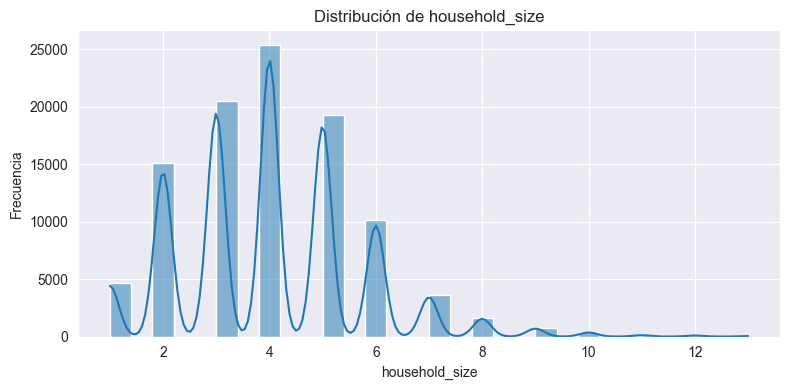

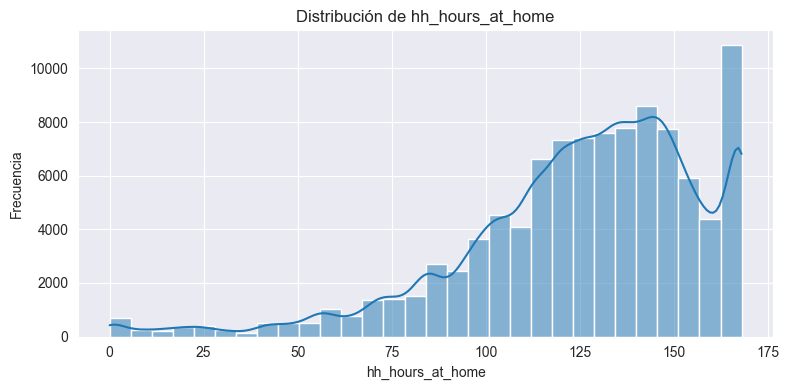

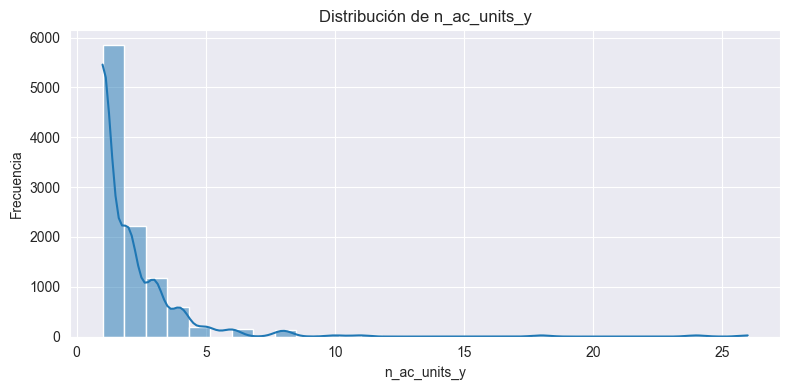

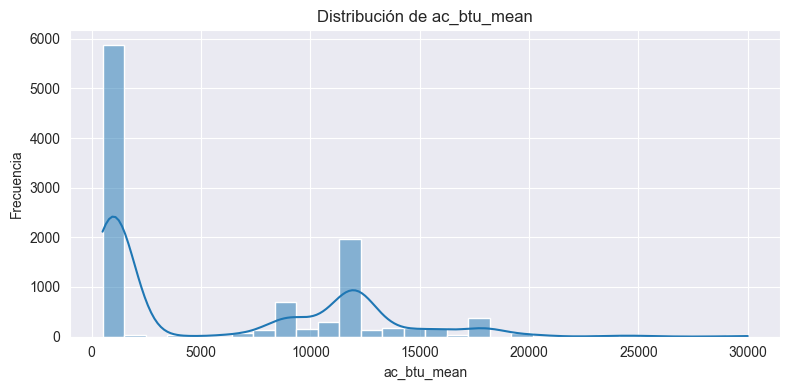

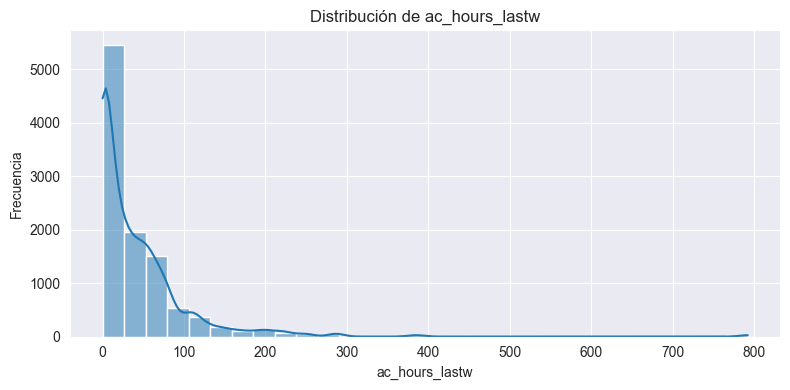

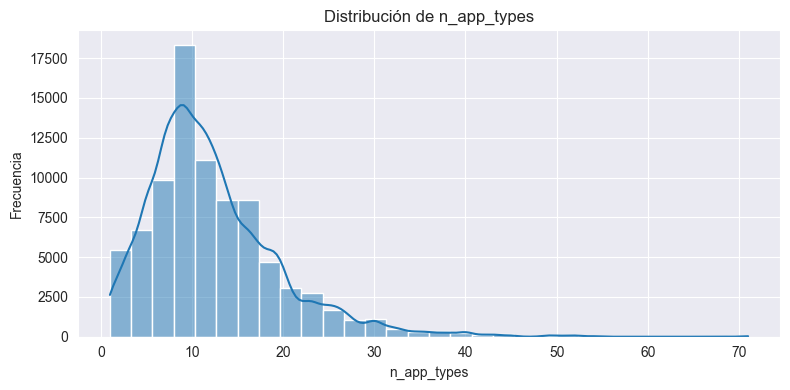

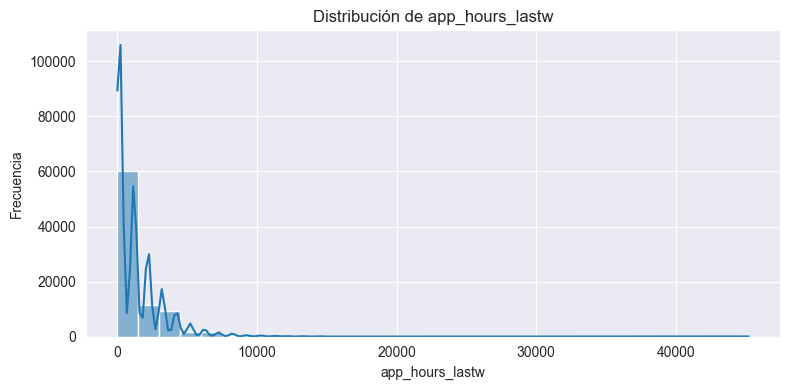

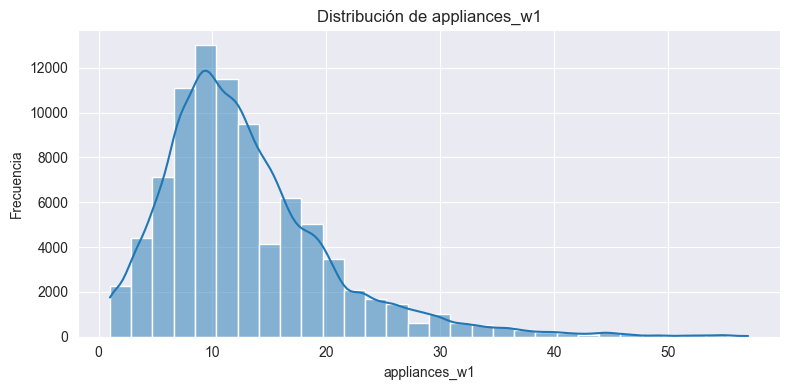

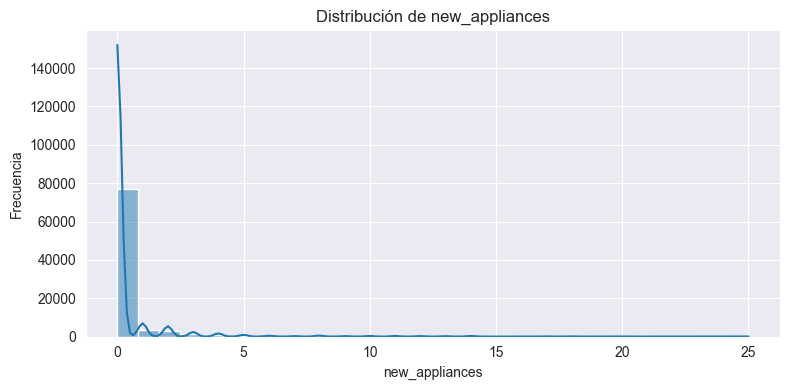

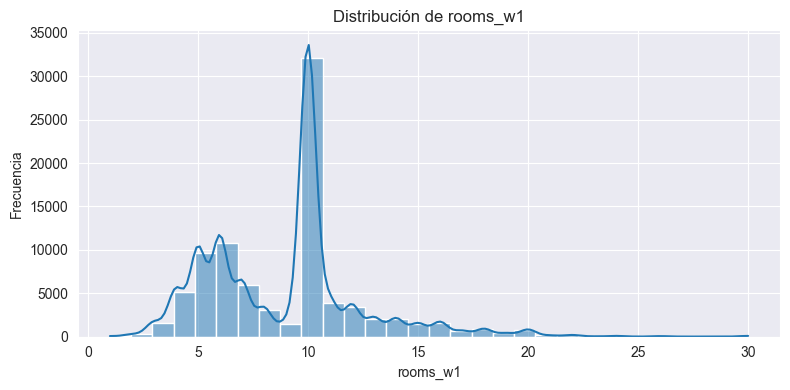

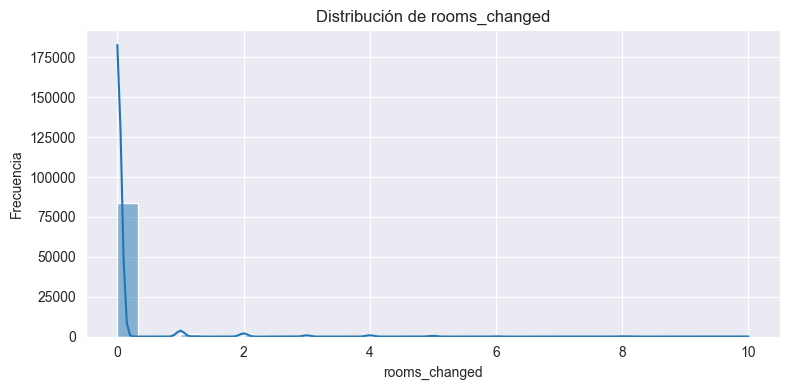

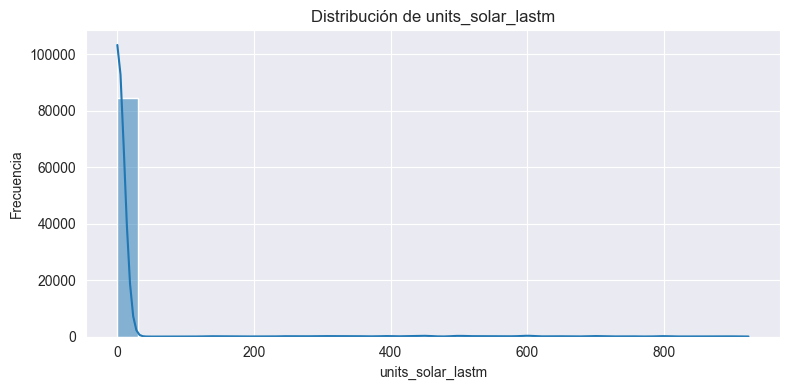

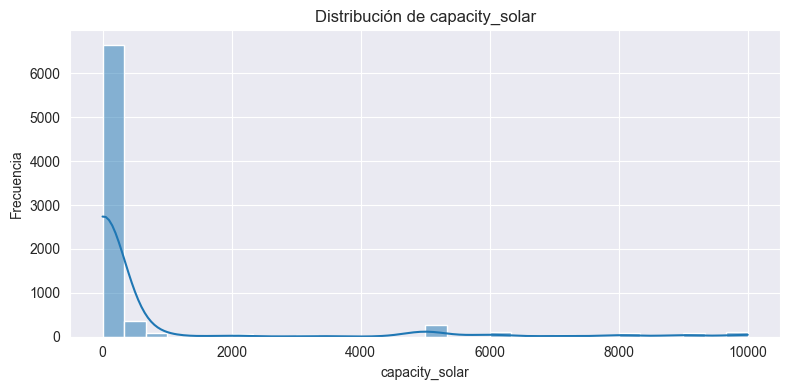

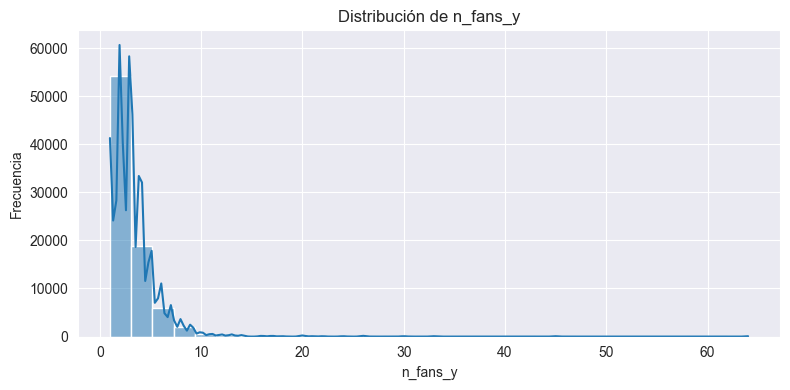

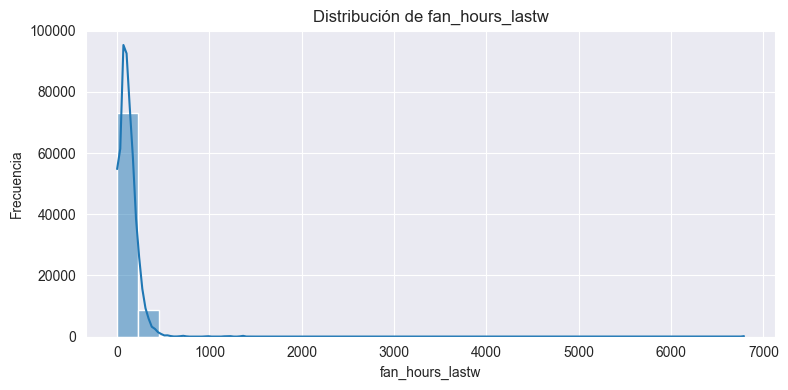

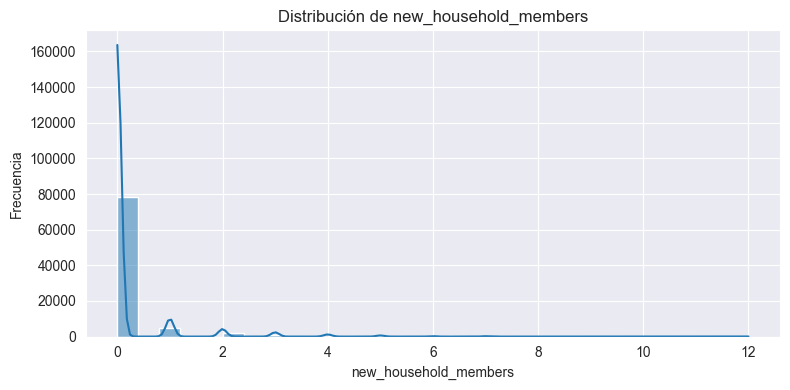

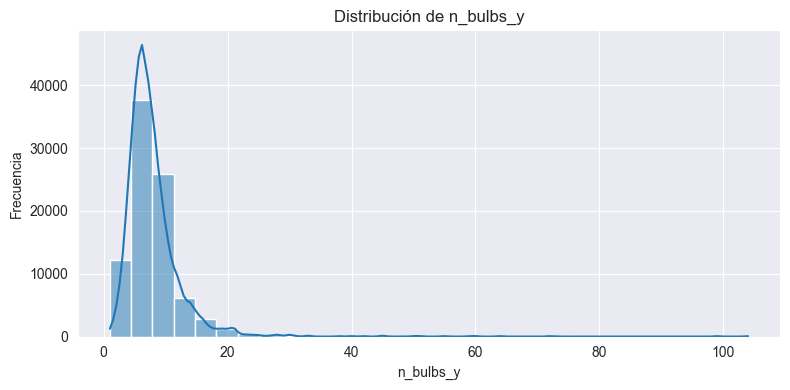

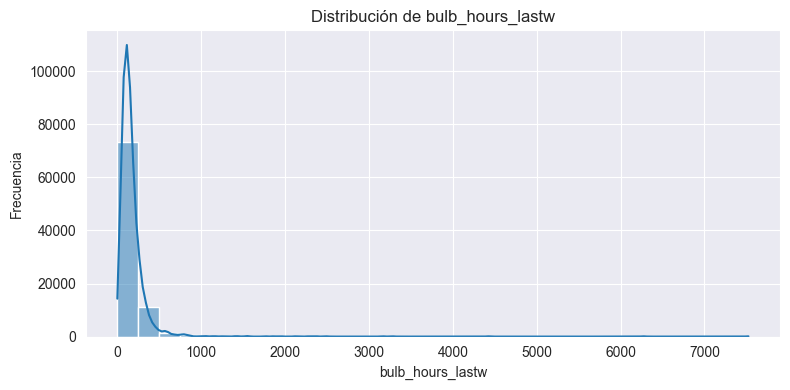

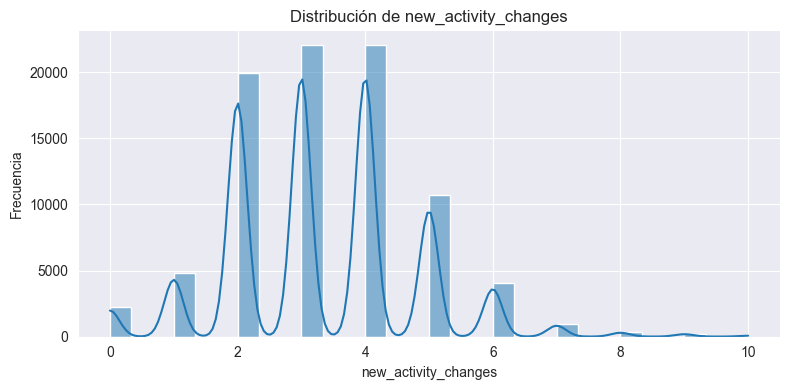

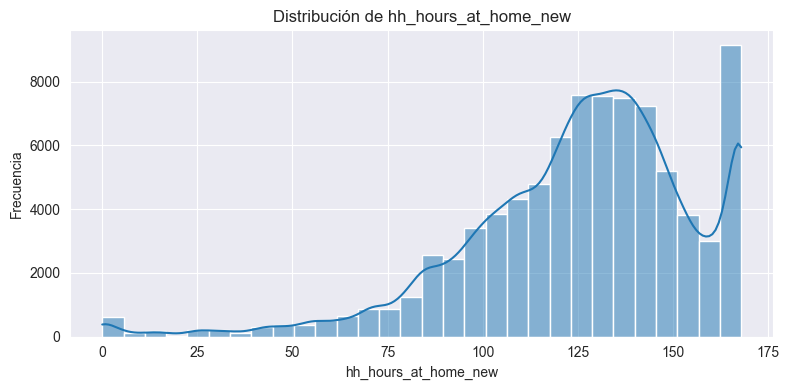

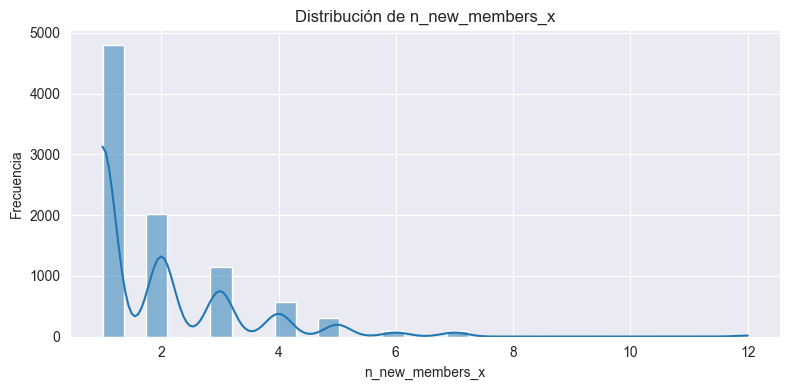

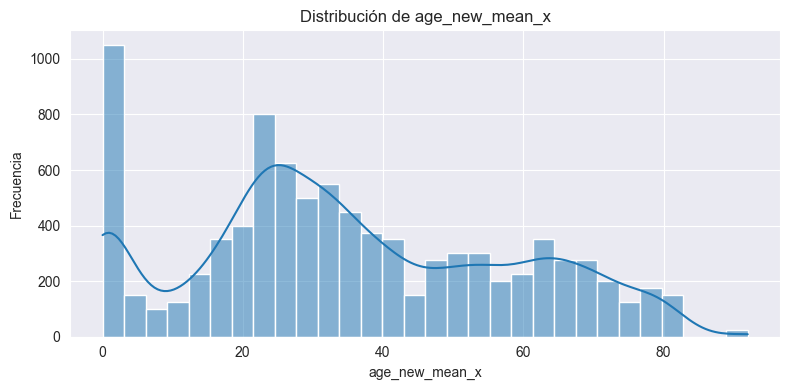

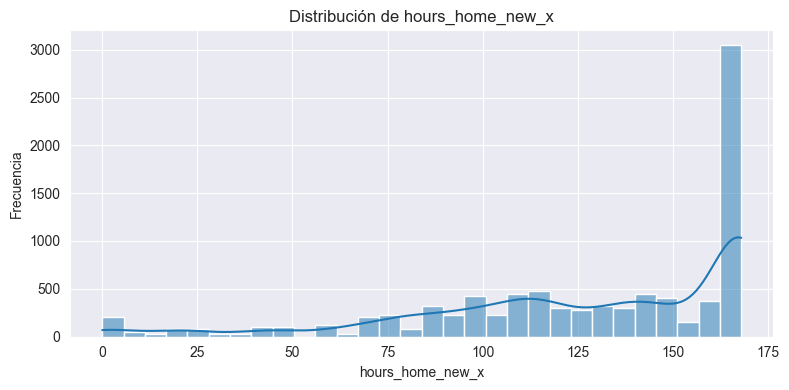

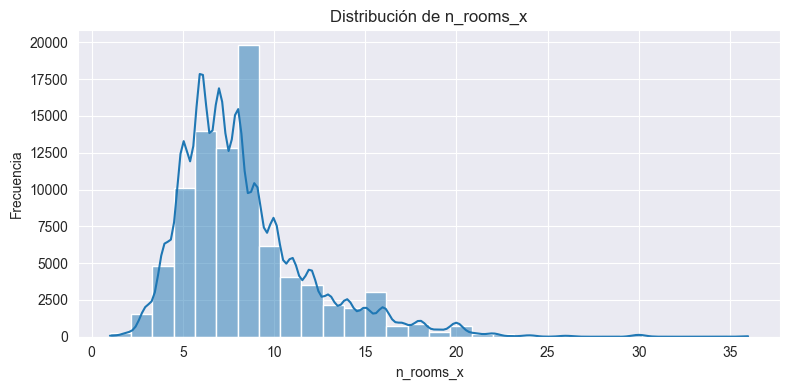

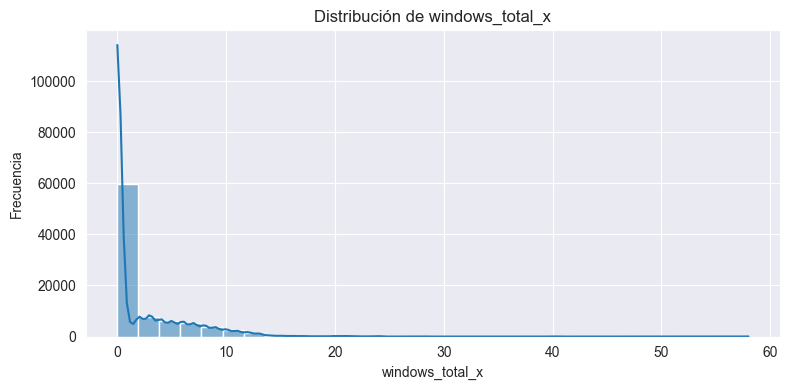

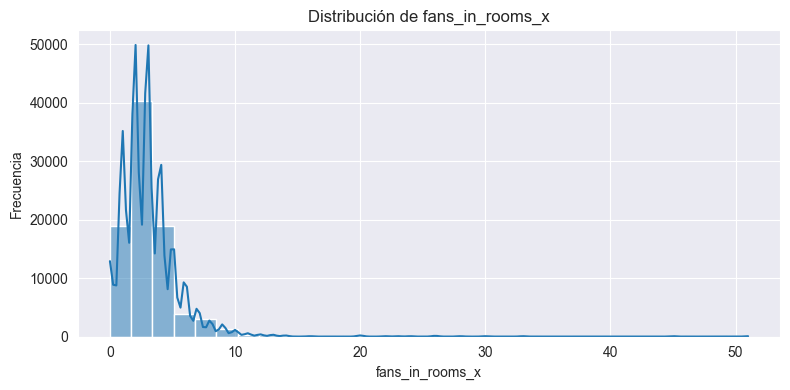

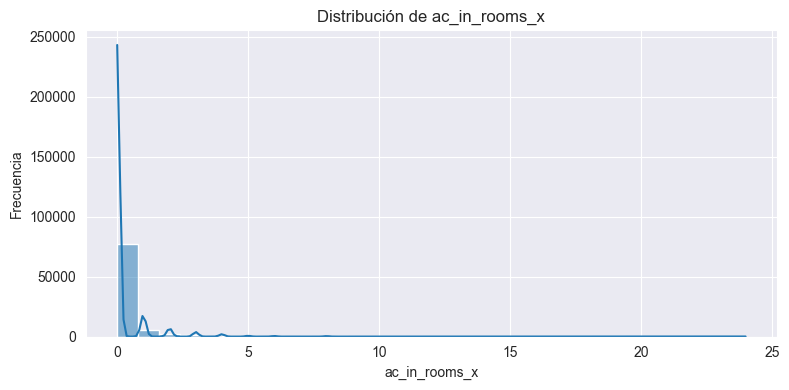

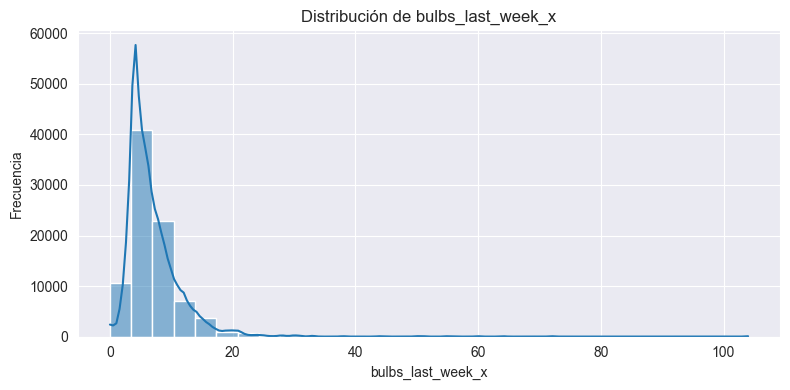

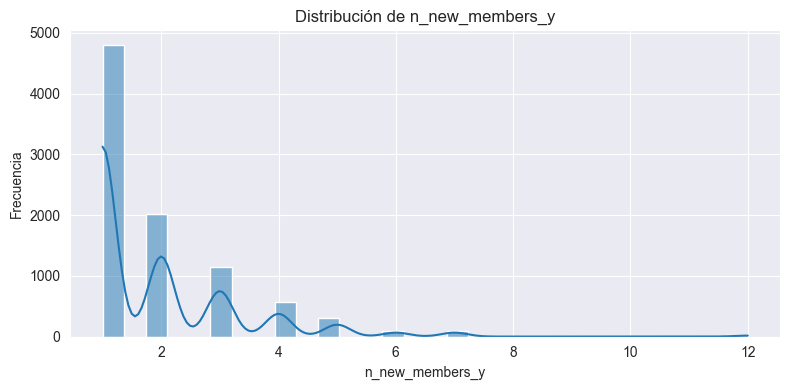

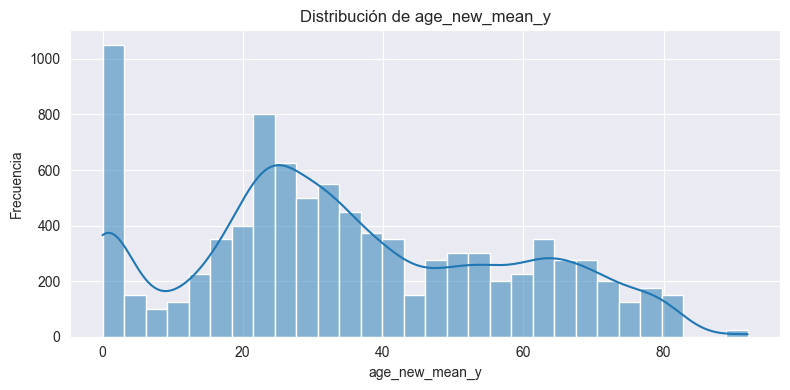

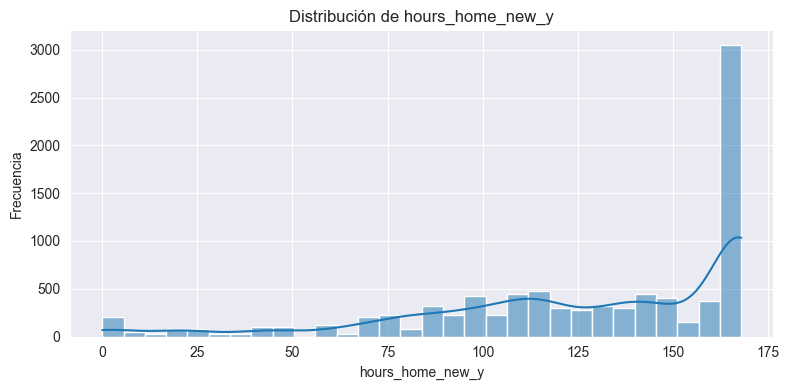

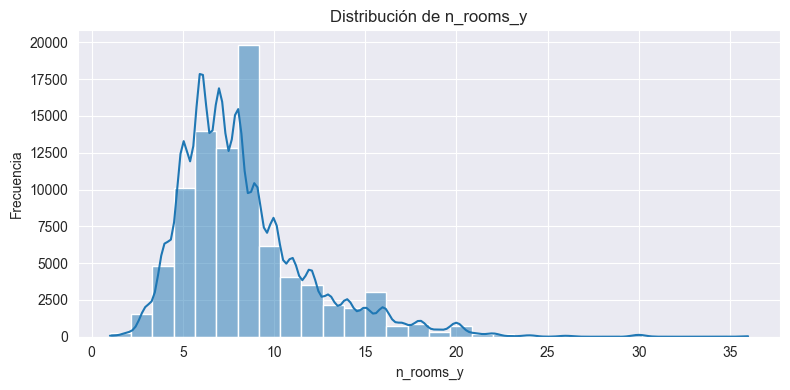

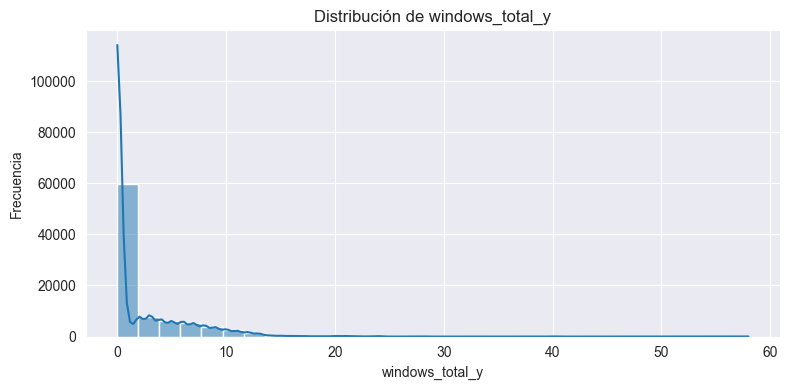

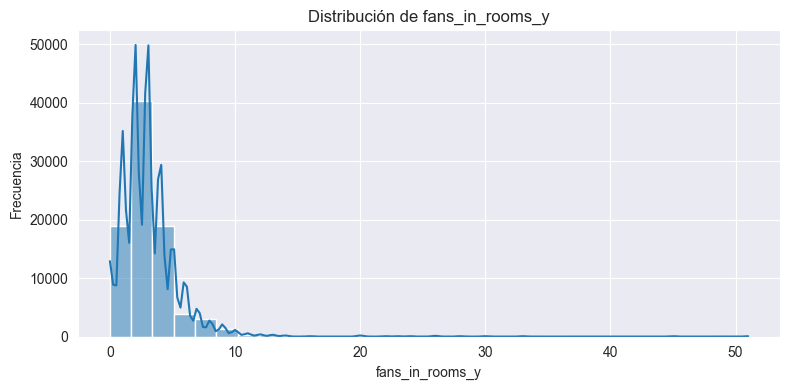

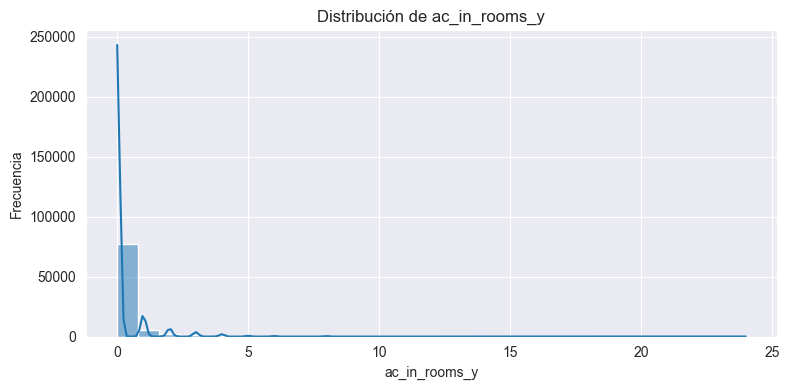

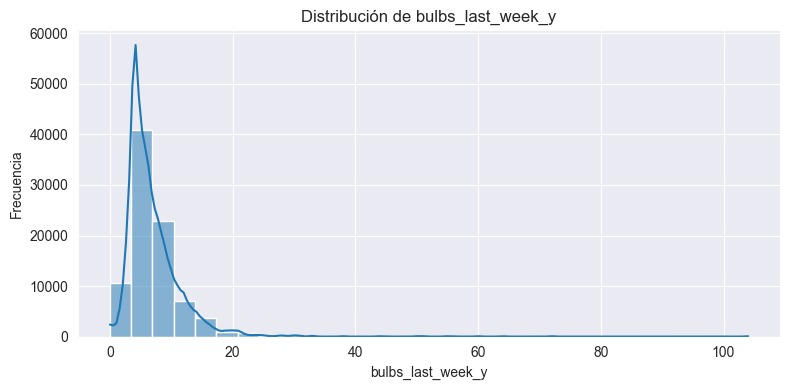

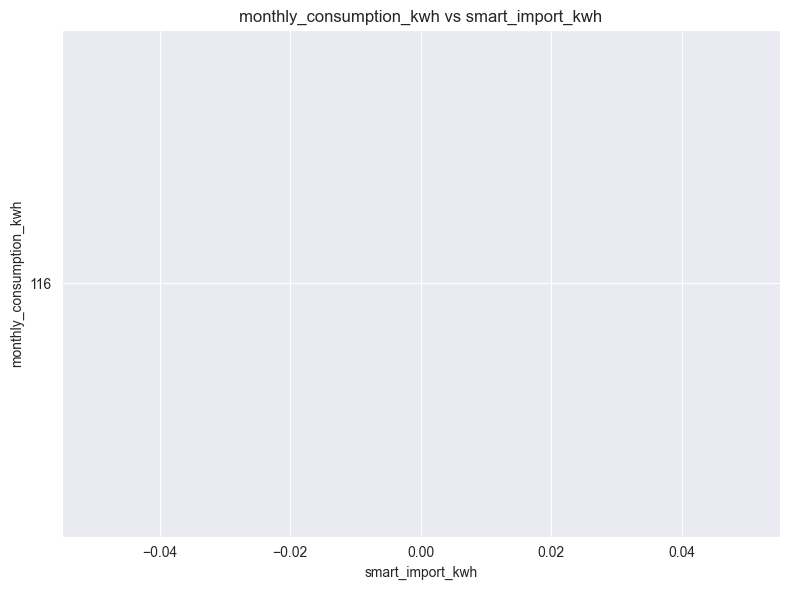

In [72]:
# 1) Filtrar solo numéricas, no vacías ni constantes
numeric_df = df_final3.select_dtypes(include='number')\
                      .dropna(axis=1, how='all')
numeric_df = numeric_df.loc[:, numeric_df.nunique(dropna=True) > 1]

numeric_columns = numeric_df.columns

# 2) Histograma + KDE para cada variable
for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(numeric_df[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

# 3) Scatter plot de ejemplo: Consumo mensual vs Consumo smart 15 min
# Cambia estas dos columnas por las que prefieras analizar
x_var = 'smart_import_kwh'
y_var = 'monthly_consumption_kwh'

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_final3[x_var],
    y=df_final3[y_var],
    alpha=0.6
)
plt.title(f"{y_var} vs {x_var}")
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.tight_layout()
plt.show()


**10.2. Análisis de variables categóricas:**

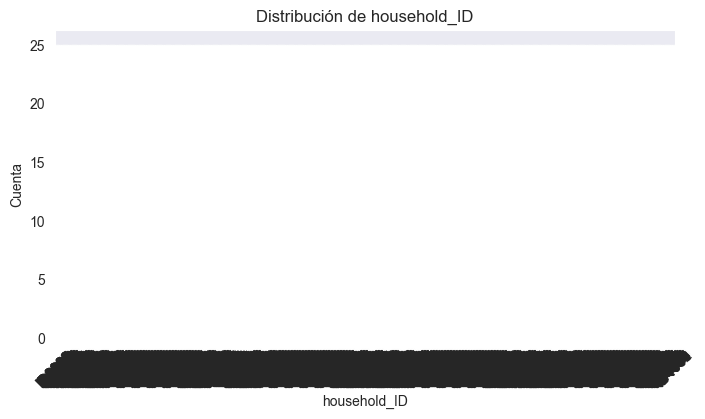

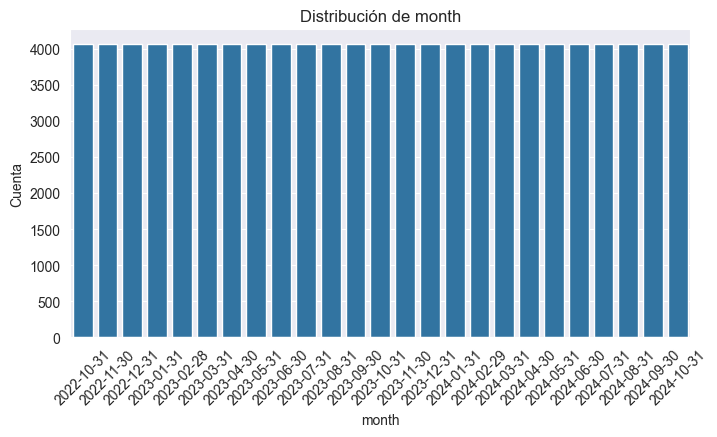

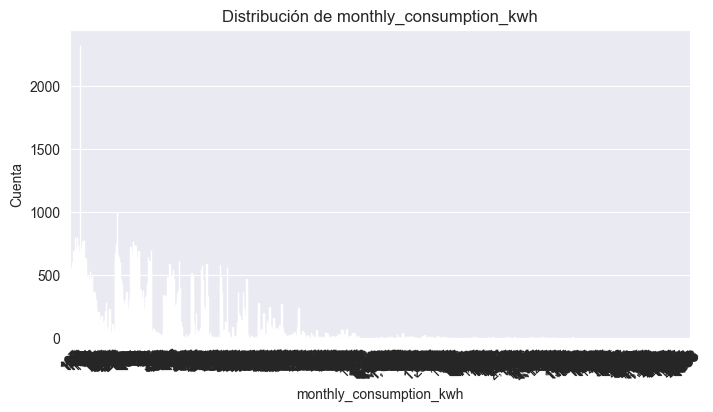

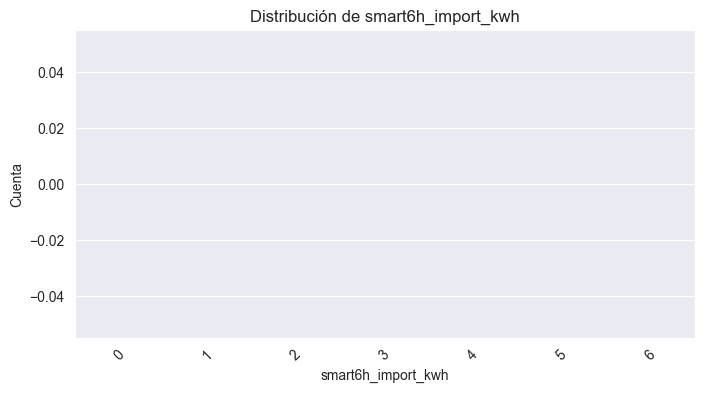

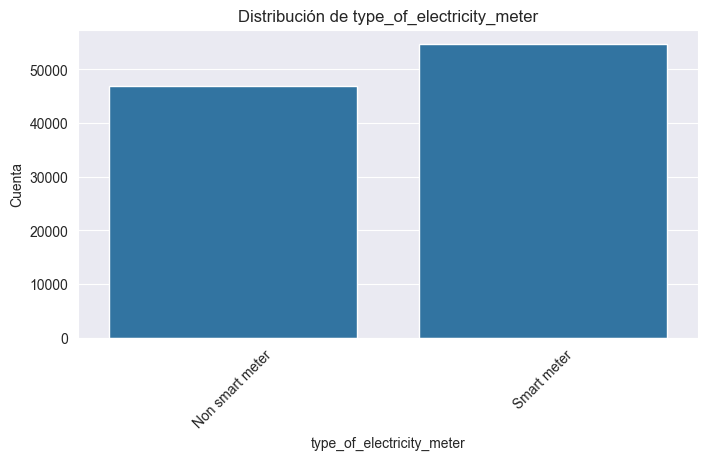

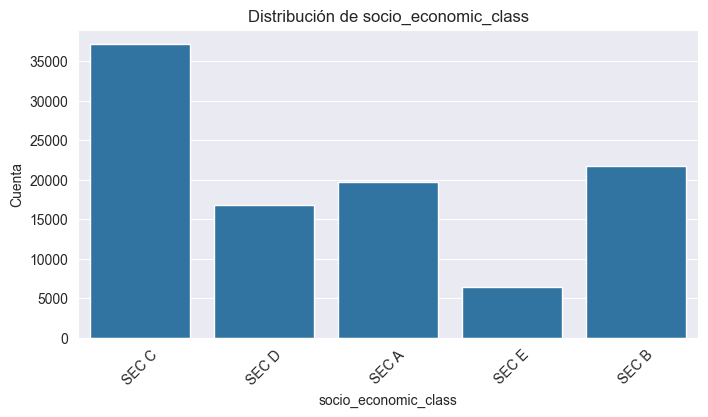

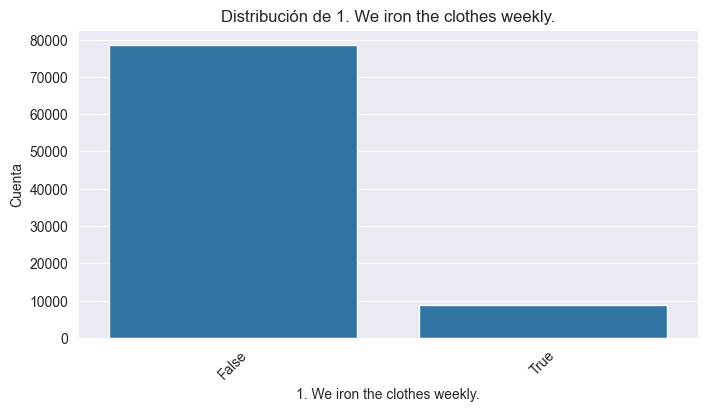

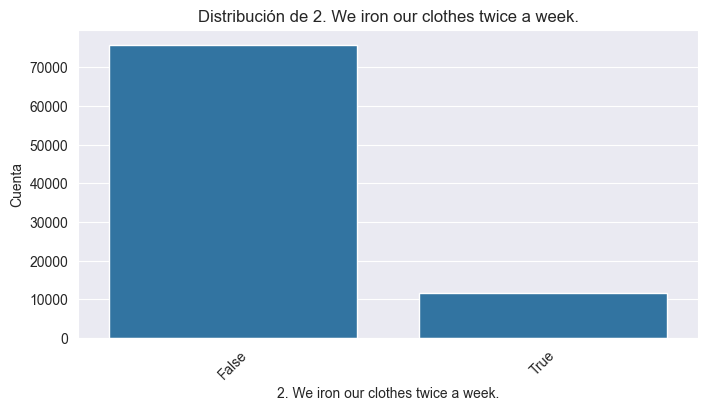

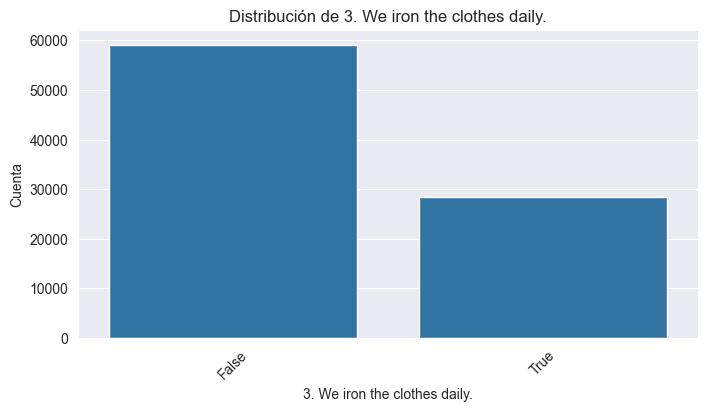

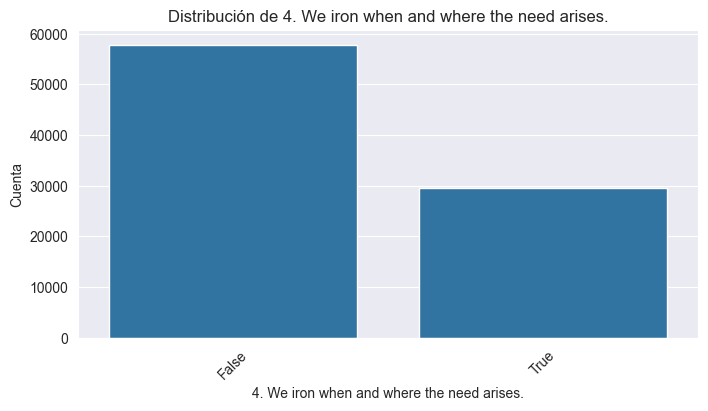

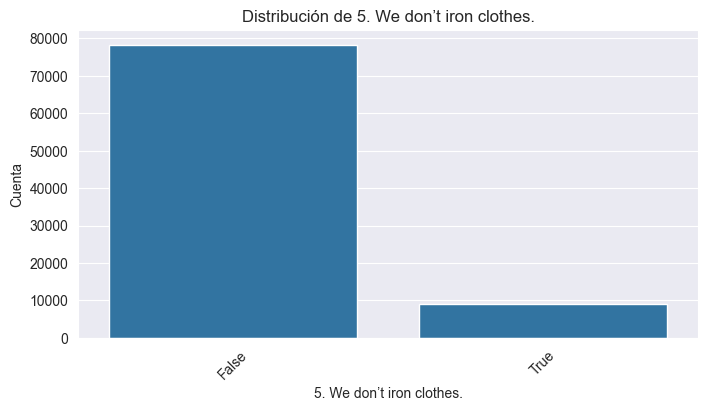

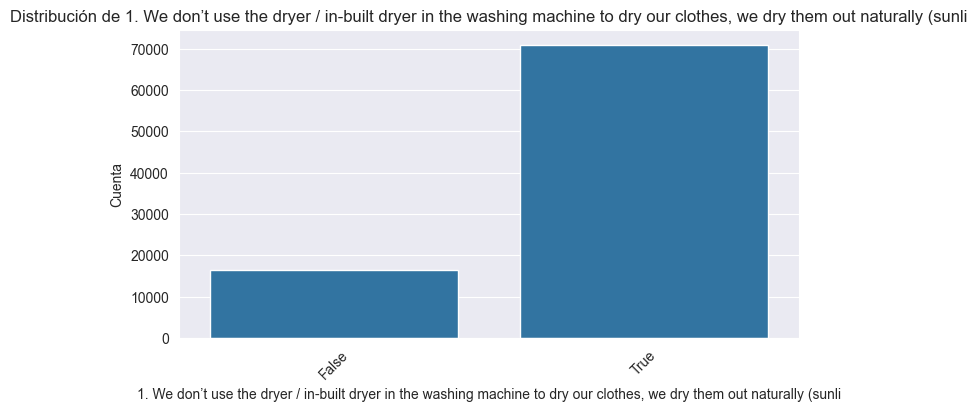

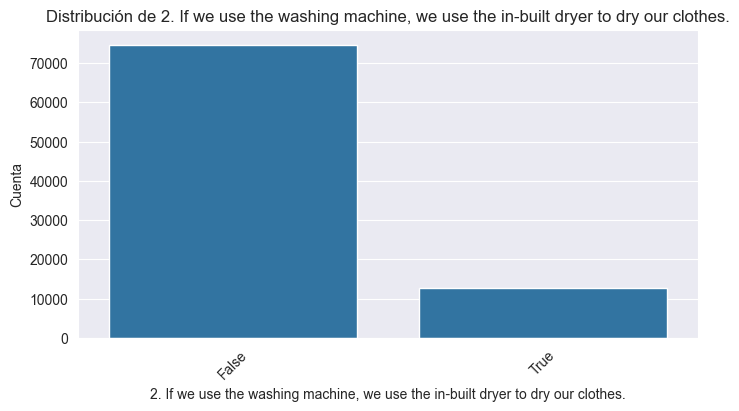

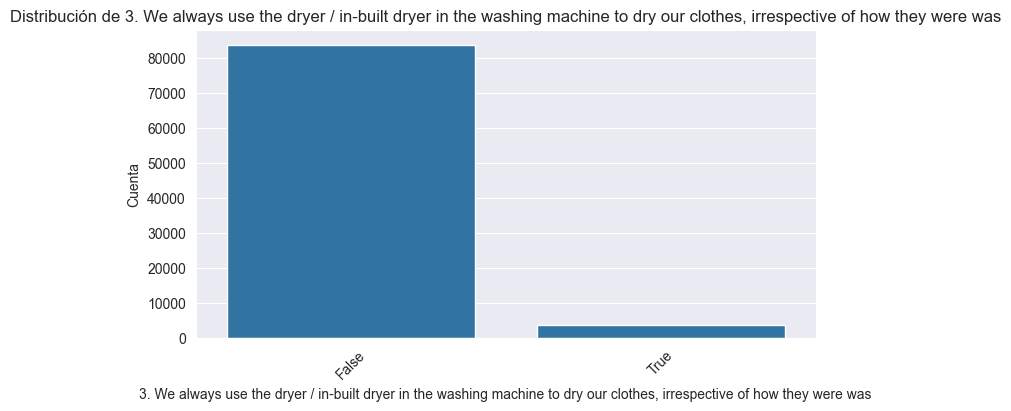

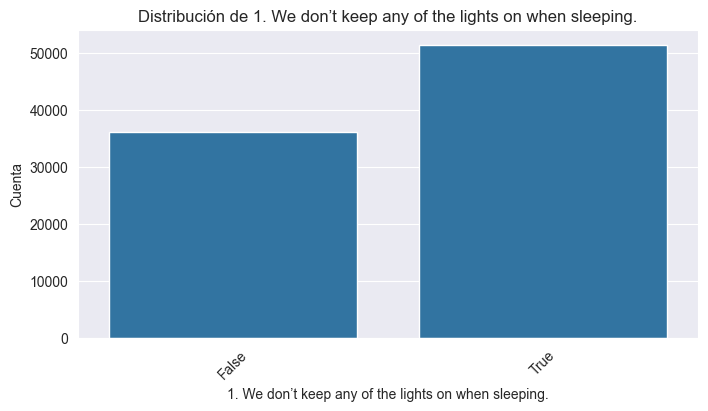

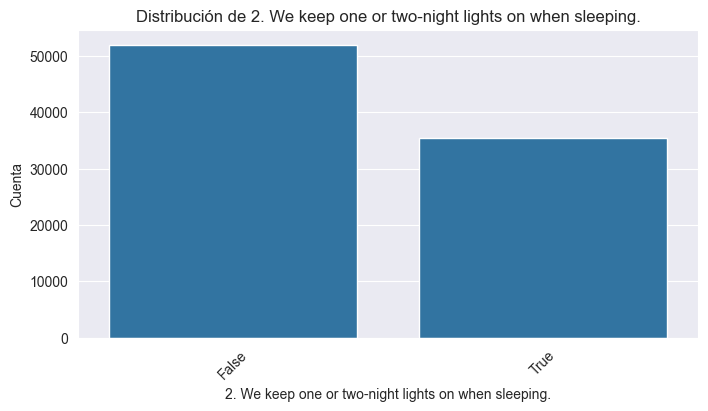

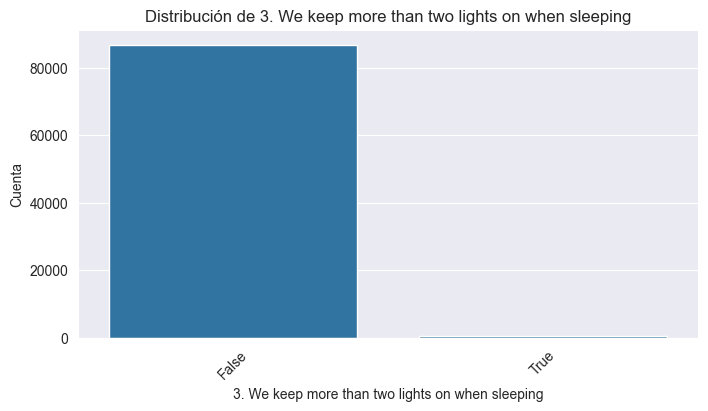

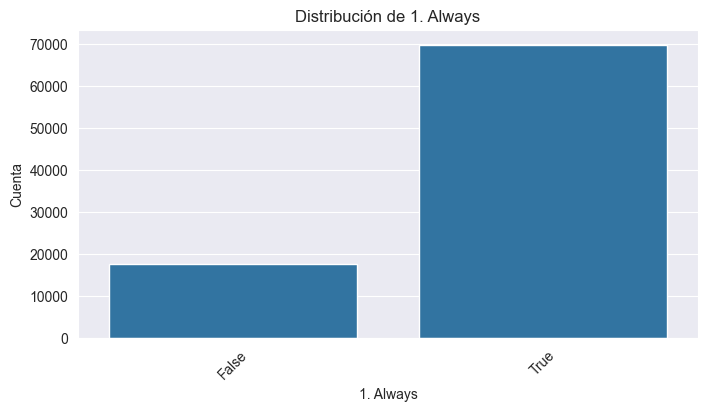

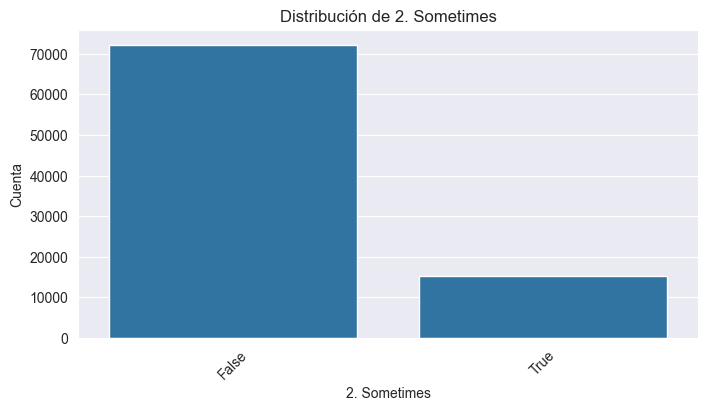

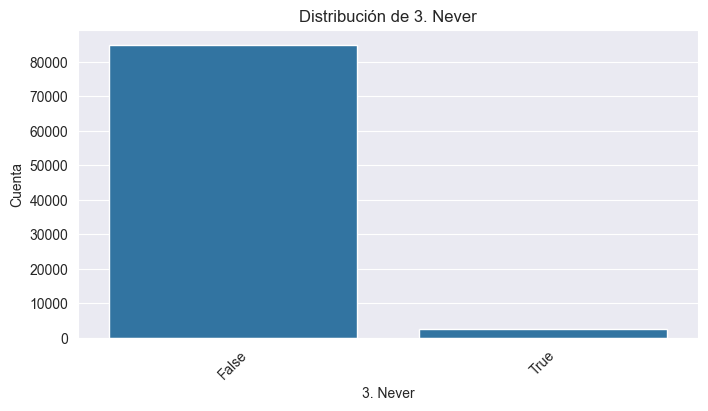

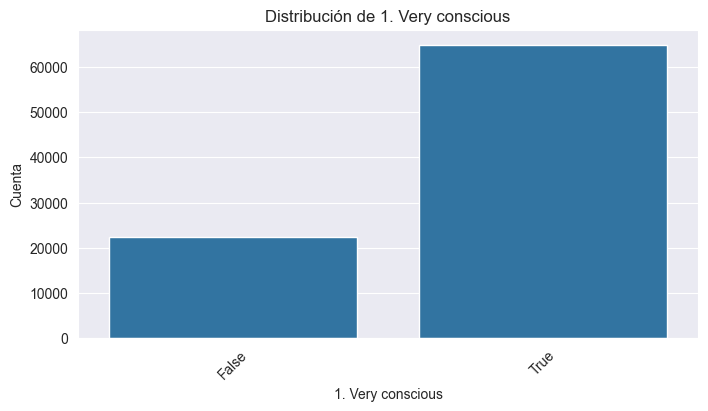

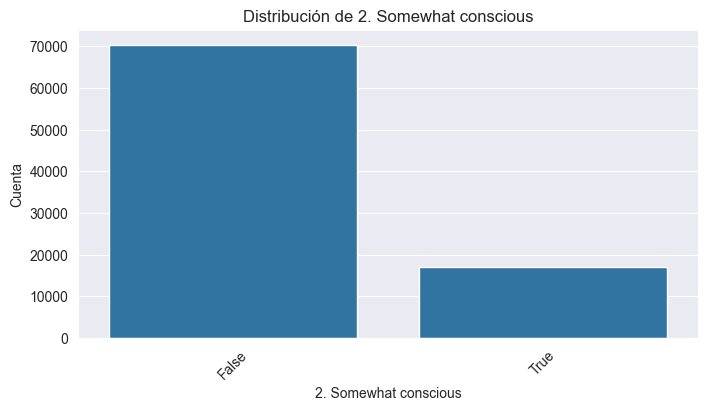

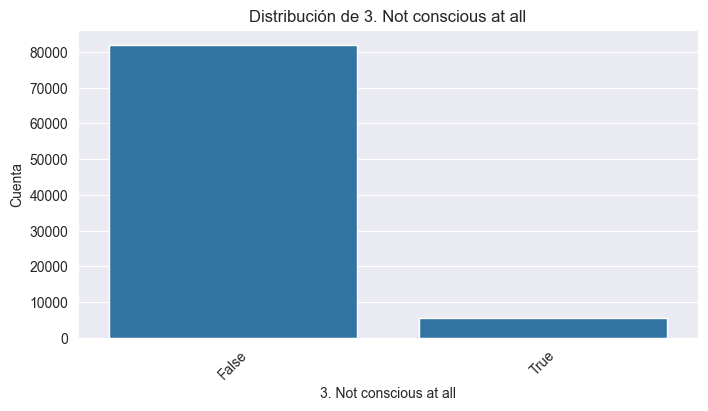

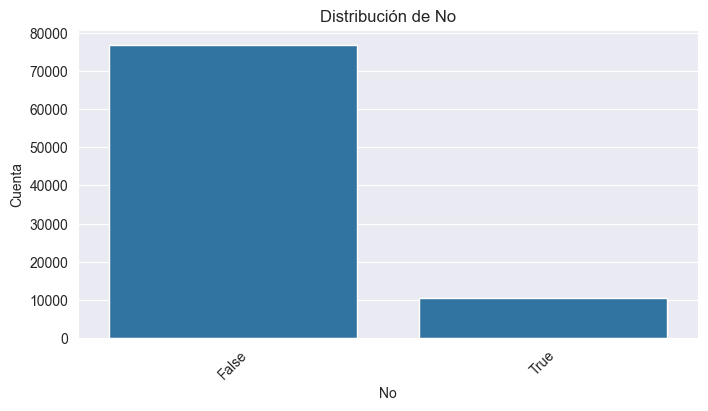

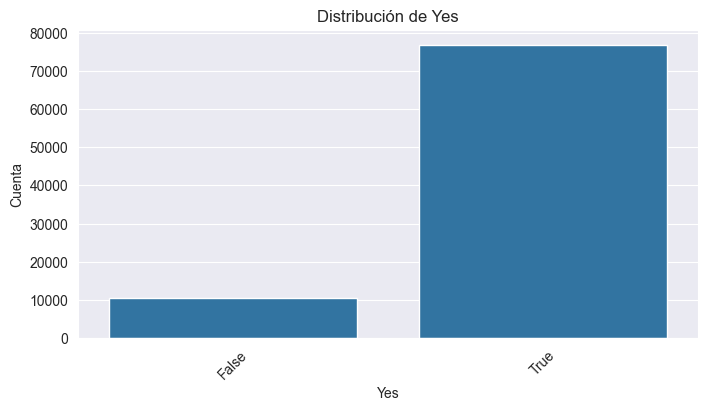

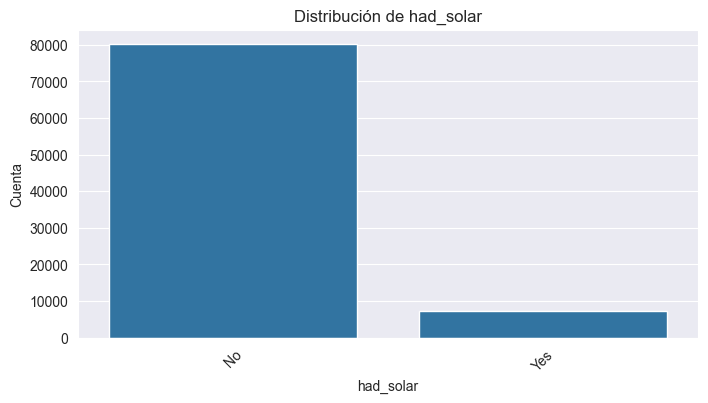

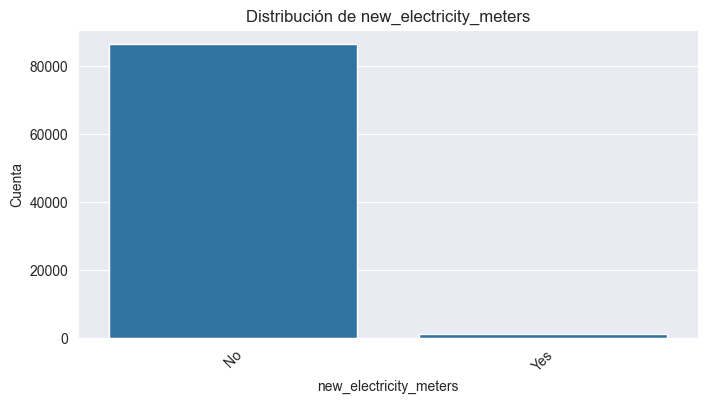

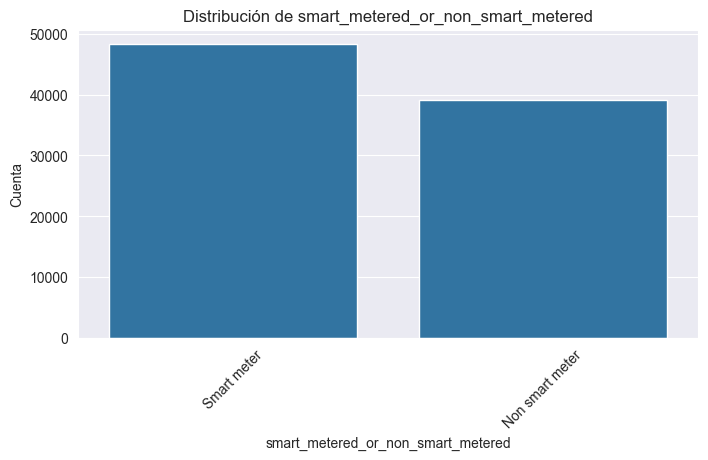

In [73]:
categorical_columns = df_final3.select_dtypes(include=['object']).columns

# Gráfico de barras para cada variable categórica
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df_final3)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Cuenta")
    plt.xticks(rotation=45)
    plt.show()

**Paso 11. Combinando variables**

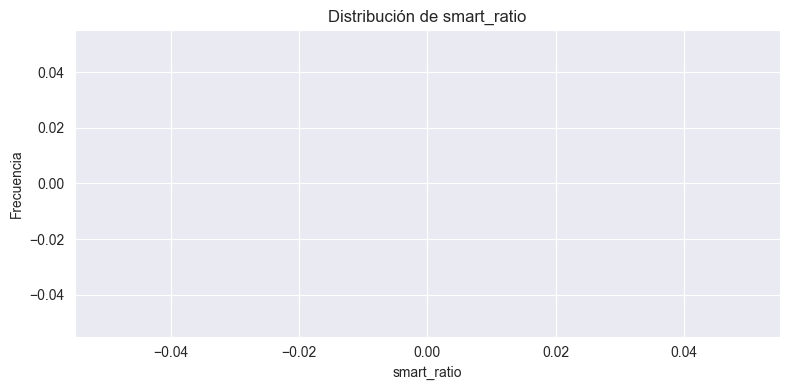

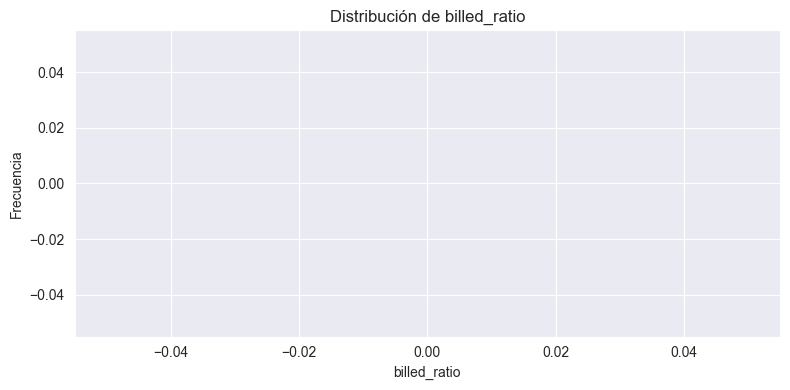

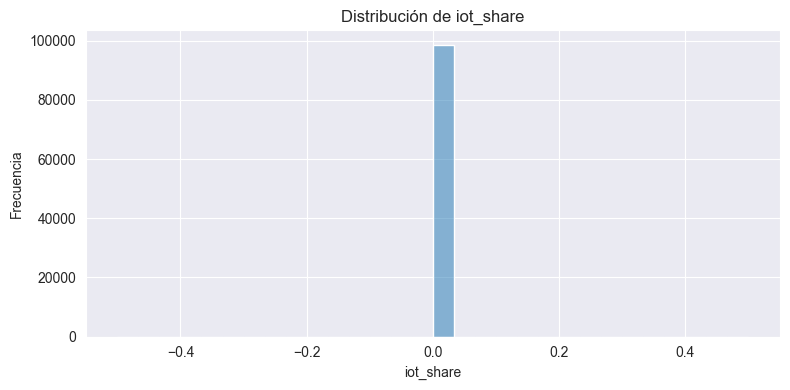

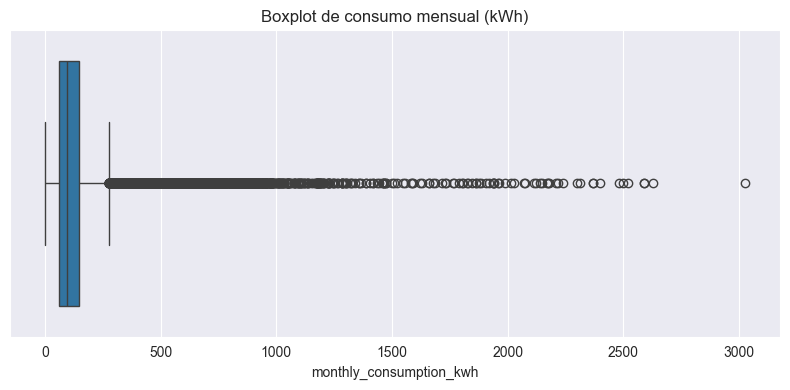

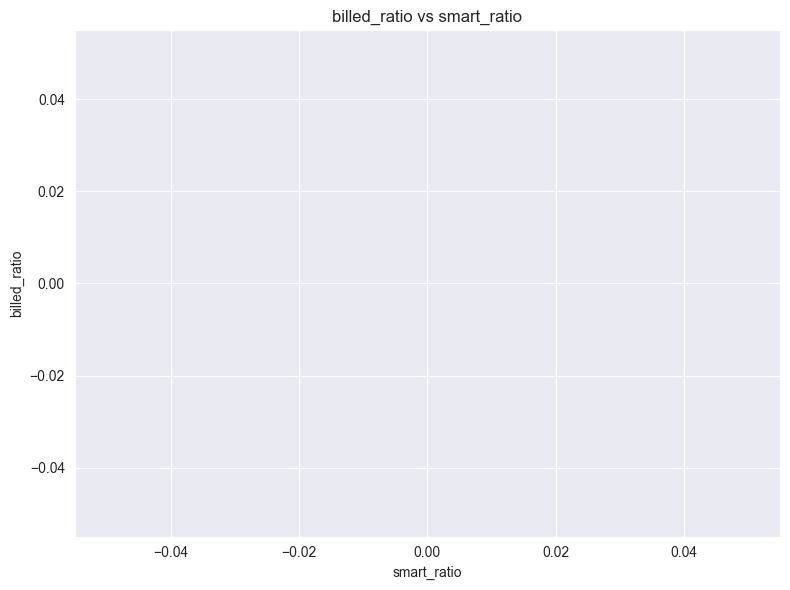

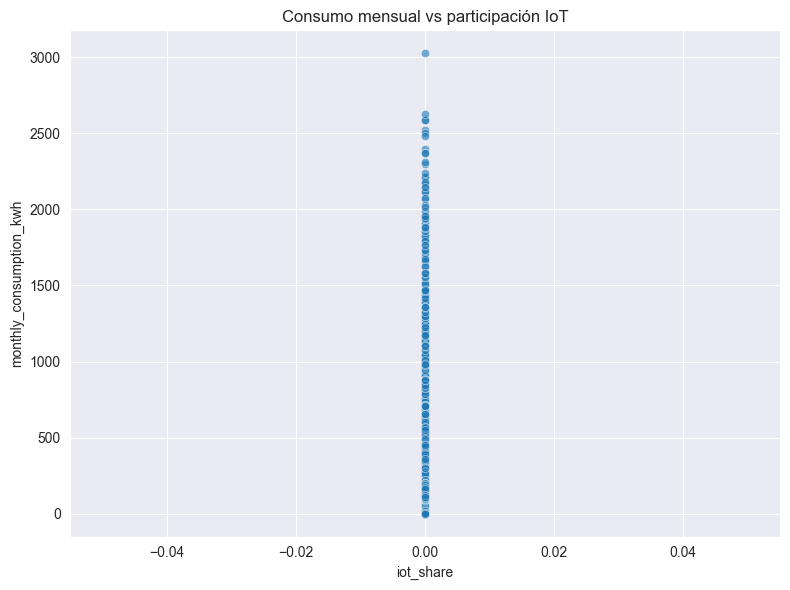

In [74]:
# 1) Copia de df_final3 y conversión a numérico
df = df_final3.copy()

# Columnas que intervienen en los ratios
cols_to_numeric = [
    'smart_import_kwh',
    'monthly_consumption_kwh',
    'billed_consumption_kwh'
] + [c for c in df.columns if c.endswith('_iot_monthly')]

for c in cols_to_numeric:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Opcional: eliminar filas sin consumo mensual válido
df = df[df['monthly_consumption_kwh'] > 0]

# 2) Cálculo de ratios y share
df['smart_ratio']  = df['smart_import_kwh']  / df['monthly_consumption_kwh']
df['billed_ratio'] = df['billed_consumption_kwh'] / df['monthly_consumption_kwh']
df['iot_total_monthly'] = df[[c for c in cols_to_numeric if c.endswith('_iot_monthly')]].sum(axis=1)
df['iot_share']    = df['iot_total_monthly'] / df['monthly_consumption_kwh']

# 3) Histogramas y KDE
for var in ['smart_ratio','billed_ratio','iot_share']:
    plt.figure(figsize=(8,4))
    sns.histplot(df[var].dropna(), bins=30, kde=True)
    plt.title(f"Distribución de {var}")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

# 4) Boxplot del consumo mensual total
plt.figure(figsize=(8,4))
sns.boxplot(x=df['monthly_consumption_kwh'].dropna())
plt.title("Boxplot de consumo mensual (kWh)")
plt.xlabel("monthly_consumption_kwh")
plt.tight_layout()
plt.show()

# 5) Scatter plots de ejemplo
plt.figure(figsize=(8,6))
sns.scatterplot(x='smart_ratio', y='billed_ratio', data=df, alpha=0.6)
plt.title("billed_ratio vs smart_ratio")
plt.xlabel("smart_ratio")
plt.ylabel("billed_ratio")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x='iot_share', y='monthly_consumption_kwh', data=df, alpha=0.6)
plt.title("Consumo mensual vs participación IoT")
plt.xlabel("iot_share")
plt.ylabel("monthly_consumption_kwh")
plt.tight_layout()
plt.show()

**Paso 12. Limpieza de datos:**

In [75]:
df_limpieza = df_final3.copy()
print(df_limpieza.isnull().sum())

household_ID                    0
month                           0
monthly_consumption_kwh       590
smart_import_kwh           101575
billed_consumption_kwh     101575
                            ...  
w2_12/09/2024                   0
w2_12/10/2024                   0
w2_12/12/2024                   0
w2_12/15/2024                   0
w2_12/17/2024                   0
Length: 314, dtype: int64


In [76]:
missing_percentage = (df_limpieza.isnull().sum() / len(df)) * 100
missing_percentage

household_ID                 0.000000
month                        0.000000
monthly_consumption_kwh      0.598402
smart_import_kwh           103.021421
billed_consumption_kwh     103.021421
                              ...    
w2_12/09/2024                0.000000
w2_12/10/2024                0.000000
w2_12/12/2024                0.000000
w2_12/15/2024                0.000000
w2_12/17/2024                0.000000
Length: 314, dtype: float64

Paso 13. Tipos de datos

In [77]:
# Columnas a convertir
cols = ['smart_import_kwh', 'billed_consumption_kwh']

print("Tipos de datos antes de la conversión:")
print(df[cols].dtypes)

# Convertir a numérico (float)
df['smart_import_kwh'] = pd.to_numeric(df['smart_import_kwh'], errors='coerce')
df['billed_consumption_kwh'] = pd.to_numeric(df['billed_consumption_kwh'], errors='coerce')

print("\nTipos de datos después de la conversión:")
print(df[cols].dtypes)

Tipos de datos antes de la conversión:
smart_import_kwh          float64
billed_consumption_kwh    float64
dtype: object

Tipos de datos después de la conversión:
smart_import_kwh          float64
billed_consumption_kwh    float64
dtype: object


In [78]:
df.dtypes

household_ID                object
month                       object
monthly_consumption_kwh    float64
smart_import_kwh           float64
billed_consumption_kwh     float64
                            ...   
w2_12/17/2024                 bool
smart_ratio                float64
billed_ratio               float64
iot_total_monthly          float64
iot_share                  float64
Length: 318, dtype: object

Paso 14. Datos inconsistentes

In [79]:
# 1) Convierte la columna a numérico (pon NaN donde no parsee bien)
df['monthly_consumption_kwh'] = pd.to_numeric(
    df['monthly_consumption_kwh'],
    errors='coerce'
)

# 2) Define la máscara de inconsistencia
mask_incons = (df['monthly_consumption_kwh'] <= 0) | (df['monthly_consumption_kwh'].isna())

# 3) Muestra los registros inconsistentes
print("Registros inconsistentes:")
display(df[mask_incons].head(10))   # o .to_string() si no usas Jupyter

# 4) Si quieres ver cuántos son:
print(f"Número total de inconsistentes: {mask_incons.sum()}")


Registros inconsistentes:


Empty DataFrame
Columns: [household_ID, month, monthly_consumption_kwh, smart_import_kwh, billed_consumption_kwh, smart6h_import_kwh, phaseA_voltage_mean, Power Consumption (kWh)_iot_monthly, use [kW]_iot_monthly, gen [kW]_iot_monthly, House overall [kW]_iot_monthly, Dishwasher [kW]_iot_monthly, Furnace 1 [kW]_iot_monthly, Furnace 2 [kW]_iot_monthly, Home office [kW]_iot_monthly, Fridge [kW]_iot_monthly, Wine cellar [kW]_iot_monthly, Garage door [kW]_iot_monthly, Kitchen 12 [kW]_iot_monthly, Kitchen 14 [kW]_iot_monthly, Kitchen 38 [kW]_iot_monthly, Barn [kW]_iot_monthly, Well [kW]_iot_monthly, Microwave [kW]_iot_monthly, Living room [kW]_iot_monthly, Solar [kW]_iot_monthly, Ventilador_iot_monthly, PC_iot_monthly, AC_iot_monthly, Lampara_iot_monthly, TV_iot_monthly, n_ac_units_x, ac_wattage_mean, ac_hours_last_week, n_appliances, appliances_hours_last_week, n_fans_x, fan_hours_last_week, n_bulbs_x, bulbs_hours_last_week, household_size, hh_hours_at_home, type_of_electricity_meter, socio_economic_class, n_ac_units_y, ac_btu_mean, ac_hours_lastw, n_app_types, app_hours_lastw, 1. We iron the clothes weekly., 2. We iron our clothes twice a week., 3. We iron the clothes daily., 4. We iron when and where the need arises., 5. We don’t iron clothes., 1. We don’t use the dryer / in-built dryer in the washing machine to dry our clothes, we dry them out naturally (sunli, 2. If we use the washing machine, we use the in-built dryer to dry our clothes., 3. We always use the dryer / in-built dryer in the washing machine to dry our clothes, irrespective of how they were was, 1. We don’t keep any of the lights on when sleeping., 2. We keep one or two-night lights on when sleeping., 3. We keep more than two lights on when sleeping, 1. Always, 2. Sometimes, 3. Never, 1. Very conscious, 2. Somewhat conscious, 3. Not conscious at all, No, Yes, appliances_w1, new_appliances, rooms_w1, rooms_changed, had_solar, units_solar_lastm, capacity_solar, n_fans_y, fan_hours_lastw, new_electricity_meters, smart_metered_or_non_smart_metered, new_household_members, n_bulbs_y, bulb_hours_lastw, still_in_house, new_activity_changes, hh_hours_at_home_new, n_new_members_x, age_new_mean_x, hours_home_new_x, n_rooms_x, windows_total_x, fans_in_rooms_x, ac_in_rooms_x, bulbs_last_week_x, n_new_members_y, age_new_mean_y, hours_home_new_y, n_rooms_y, windows_total_y, fans_in_rooms_y, ac_in_rooms_y, ...]
Index: []

[0 rows x 318 columns]

Número total de inconsistentes: 0


Paso 15. Datos atípicos

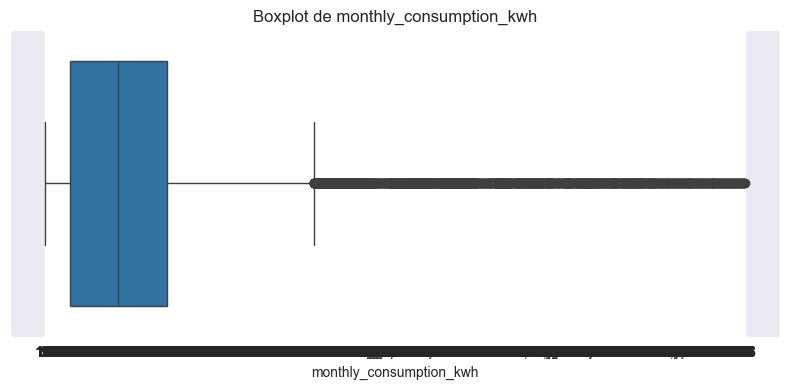

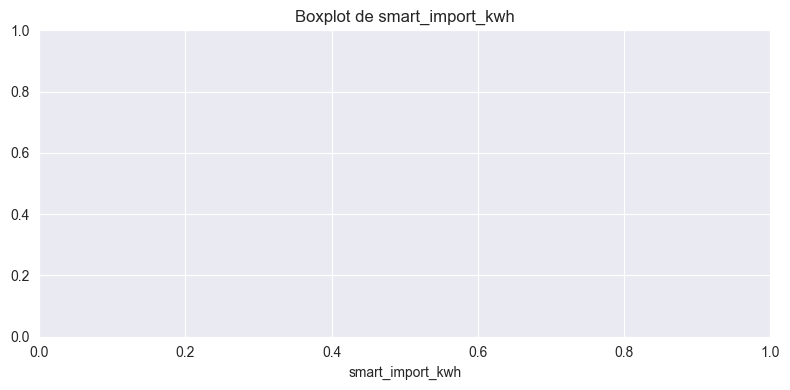

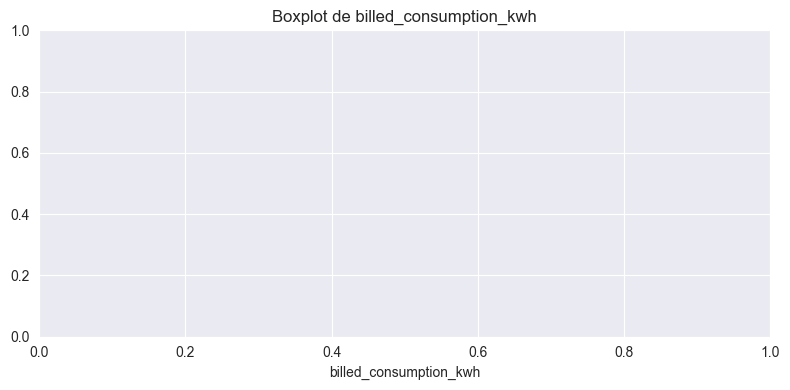

La columna 'iot_share' no se encontró en el DataFrame.
La columna 'smart_ratio' no se encontró en el DataFrame.
La columna 'billed_ratio' no se encontró en el DataFrame.


In [80]:
# Lista de variables para detectar outliers (ajusta nombres a tu df_final3)
variables_outliers = [
    'monthly_consumption_kwh',
    'smart_import_kwh',
    'billed_consumption_kwh',
    'iot_share',
    'smart_ratio',
    'billed_ratio'
]

for col in variables_outliers:
    if col in df_final3.columns:
        plt.figure(figsize=(8,4))
        sns.boxplot(x=df_final3[col].dropna())
        plt.title(f"Boxplot de {col}")
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()
    else:
        print(f"La columna '{col}' no se encontró en el DataFrame.")

In [81]:
# df_final3.to_csv('dataset.csv', index=False)